# Instacart Project
I'm applying linear regression to help predict what customers will order next based on an a dataset Instacart uploaded to [Kaggle.com](https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset).

In [1]:
import pandas as pd
import sqlite3
#Creating the database
conn = sqlite3.connect('instacart.db')

In [2]:
#Reading in each csv file and then converting them to a database table.
#df = pd.read_csv('aisles.csv')
#df.to_sql('aisles', conn)

In [3]:
#df = pd.read_csv('departments.csv')
#df.to_sql('departments', conn)

In [4]:
#df = pd.read_csv('products.csv')
#df.to_sql('products', conn)

In [5]:
#Now I'll process the larger csv's one at a time:

#df = pd.read_csv('orders.csv')
#df.to_sql('orders', conn)

In [6]:
#df = pd.read_csv('order_products__prior.csv')
#df.to_sql('order_products__prior', conn)

In [7]:
#df = pd.read_csv('order_products__train.csv')
#df.to_sql('order_products__train', conn)

In [8]:
pd.read_sql("""SELECT * FROM orders LIMIT 5;""", conn)

,index,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,2539329,1,prior,1,2,8,NaN
1,1,2398795,1,prior,2,3,7,15.0
2,2,473747,1,prior,3,3,12,21.0
3,3,2254736,1,prior,4,4,7,29.0
4,4,431534,1,prior,5,4,15,28.0


## preliminary EDA: understanding each database table

Now that everything is in place, let's perform some EDA to get to know the data. Our end goal is to (1) predict what customers will purchase next and (2) how often they do so. This may help Instacart predict busier times and when to schedule their shoppers, but hopefully there'll be some other interesting correlations popping up that I can use to draw some less obvious insights from. 

In [9]:
pd.read_sql("""SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;""", conn)

,name
0,aisles
1,departments
2,order_products__prior
3,order_products__train
4,orders
5,products


In [10]:
products_df = pd.read_sql("""SELECT * FROM products;""", conn)
products_df

,index,product_id,product_name,aisle_id,department_id
0,0,1,Chocolate Sandwich Cookies,61,19
1,1,2,All-Seasons Salt,104,13
2,2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...,...
49683,49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49685,49686,Artisan Baguette,112,3
49686,49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [11]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          49688 non-null  int64 
 1   product_id     49688 non-null  int64 
 2   product_name   49688 non-null  object
 3   aisle_id       49688 non-null  int64 
 4   department_id  49688 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


In [12]:
aisles = pd.read_sql("""SELECT * FROM aisles;""", conn)
aisles

,index,aisle_id,aisle
0,0,1,prepared soups salads
1,1,2,specialty cheeses
2,2,3,energy granola bars
3,3,4,instant foods
4,4,5,marinades meat preparation
...,...,...,...
129,129,130,hot cereal pancake mixes
130,130,131,dry pasta
131,131,132,beauty
132,132,133,muscles joints pain relief


In [13]:
departments = pd.read_sql("""SELECT * FROM departments;""", conn)
departments

,index,department_id,department
0,0,1,frozen
1,1,2,other
2,2,3,bakery
3,3,4,produce
4,4,5,alcohol
5,5,6,international
6,6,7,beverages
7,7,8,pets
8,8,9,dry goods pasta
9,9,10,bulk


Looks like we have some NaN's listed as 'missing' at the end of the departments table. We'll deal with those below once we initialize DataFrames from this database.

In [14]:
order_products__prior_df = pd.read_sql("""SELECT * FROM order_products__prior LIMIT 100;""", conn)
order_products__prior_df

,index,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0
...,...,...,...,...,...
95,95,11,1313,4,1
96,96,11,31506,5,1
97,97,12,30597,1,1
98,98,12,15221,2,1


In [15]:
product_info_df = pd.read_sql(
                """SELECT
                    order_products__prior.product_id,
                    COUNT(product_id) AS times_ordered,
                    products.product_name,
                    products.department_id,
                    departments.department AS dept_name,
                    products.aisle_id,
                    aisles.aisle AS aisle_name
                FROM order_products__prior
                JOIN products
                    USING(product_id)
                JOIN aisles
                    USING(aisle_id)
                JOIN departments
                    USING(department_id)
                GROUP BY product_id
                ORDER by times_ordered DESC;
                """, conn)
product_info_df.head()

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
0,24852,15450,Banana,4,produce,24,fresh fruits
1,13176,12409,Bag of Organic Bananas,4,produce,24,fresh fruits
2,21137,8528,Organic Strawberries,4,produce,24,fresh fruits
3,21903,7852,Organic Baby Spinach,4,produce,123,packaged vegetables fruits
4,47209,6857,Organic Hass Avocado,4,produce,24,fresh fruits


Now that we have a DataFrame to work with and some string columns, let's contend with the missing departments (which are accompanied by 'missing' aisles):

In [16]:
missing_departments_and_aisles = product_info_df.loc[product_info_df['dept_name'].isin(['None', 'none', 'missing', 'NaN', 'n/a'])]
missing_departments_and_aisles

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
667,41149,252,Organic Riced Cauliflower,21,missing,100,missing
2521,14010,74,Organic Mango Yogurt,21,missing,100,missing
2741,7035,68,Peanut Butter Ice Cream Cup,21,missing,100,missing
2939,38510,62,Organic Celery Bunch,21,missing,100,missing
2940,38452,62,Organic Whole Milk Washington Black Cherry Yogurt,21,missing,100,missing
...,...,...,...,...,...,...,...
35338,690,1,Vegetable Hearty Garden Soup,21,missing,100,missing
35378,491,1,Pompelmo Water,21,missing,100,missing
35384,440,1,Crossovers Olive Thyme Almond,21,missing,100,missing
35404,297,1,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",21,missing,100,missing


In [17]:
#How many products are here in thie grouped-by-product df of orders?
len(product_info_df)

35449

In [18]:
#What percent of these records have missing department information?
len(missing_departments_and_aisles)/len(product_info_df)

0.014161189314226072

Hmm, 1.4 percent of the product_info_df isn't a lot and going through 502 records to add those values in doesn't seem like a good use of time for anyone. Additionally, while adding the department in wouldn't be too difficult to intuit (there are only twenty departments), adding the aisle information would be more cumbersome (134 aisles to choose from!). 

One last consideration: it looks like some products with missing departments were only ordered once; they're probably not going to be ordered again too often. However, "Organic Riced Cauliflower" makes up 252 orders. Maybe I could go through and just add department/aisle info in for some of the most popular items. 

In [19]:
missing_departments_and_aisles[missing_departments_and_aisles['times_ordered'] > 50]

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
667,41149,252,Organic Riced Cauliflower,21,missing,100,missing
2521,14010,74,Organic Mango Yogurt,21,missing,100,missing
2741,7035,68,Peanut Butter Ice Cream Cup,21,missing,100,missing
2939,38510,62,Organic Celery Bunch,21,missing,100,missing
2940,38452,62,Organic Whole Milk Washington Black Cherry Yogurt,21,missing,100,missing


Okay, this is a managable amount and may prove helpful since they're at least somewhat popular items. Below, I find which aisle (and, sometimes, department) they'd belong in using a str.contains() method. For concision purposes, I comment that out and then use a technique I found [here](https://stackoverflow.com/questions/19226488/change-one-value-based-on-another-value-in-pandas) to add in the missing dept/aisle info for these five more popular records:

In [20]:
#product_info_df[product_info_df['product_name'].str.contains('Cauliflower')]
#Ok, the cauliflower one goes in the 'fresh vegetables' isle:
product_info_df.loc[product_info_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
product_info_df.loc[product_info_df['product_name'] == 'Organic Riced Cauliflower', 'aisle_name'] = 'fresh vegetables'
#product_info_df[product_info_df['product_name'].str.contains('Yogurt')]
#This aisle will be 'yogurt':
product_info_df.loc[product_info_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
product_info_df.loc[product_info_df['product_name'] == 'Organic Mango Yogurt', 'aisle_name'] = 'yogurt'
#product_info_df[product_info_df['product_name'].str.contains('Ice Cream')]
#This department will be 'frozen' and its aisle will be 'ice cream ice':
product_info_df.loc[product_info_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
product_info_df.loc[product_info_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'aisle_name'] = 'ice cream ice'
#product_info_df[product_info_df['product_name'].str.contains('Celery Bunch')]
#This is in the 'fresh vegetables' aisle:
product_info_df.loc[product_info_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
product_info_df.loc[product_info_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
#This last one is another yogurt product:
product_info_df.loc[product_info_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'
product_info_df.loc[product_info_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'aisle_name'] = 'yogurt'

With those more significant records salvaged, we can drop the remaining (and less significant) missing ones:

In [21]:
product_info_df = product_info_df[product_info_df['dept_name'] != 'missing']
#The df should have 34,952 records (the original length of 35,449 minus the 497 remaining missing ones).
len(product_info_df)

34952

## deeper EDA: looking for patterns and relationships among the data

### Exploring the products in the database

Let's start grasping the big picture when it comes to these 34,952 unique products. Perhaps a good place to start is the most popular 100:

In [22]:
pd.options.mode.chained_assignment = None

top_100_products = product_info_df[0:100]
top_100_products.drop(['product_id', 'department_id', 'aisle_id', 'aisle_name'], axis=1, inplace=True)
top_100_products.sort_values('times_ordered',inplace=True)

In [23]:
cols = ['product_name', 'times_ordered']
top_100_products = top_100_products[cols]

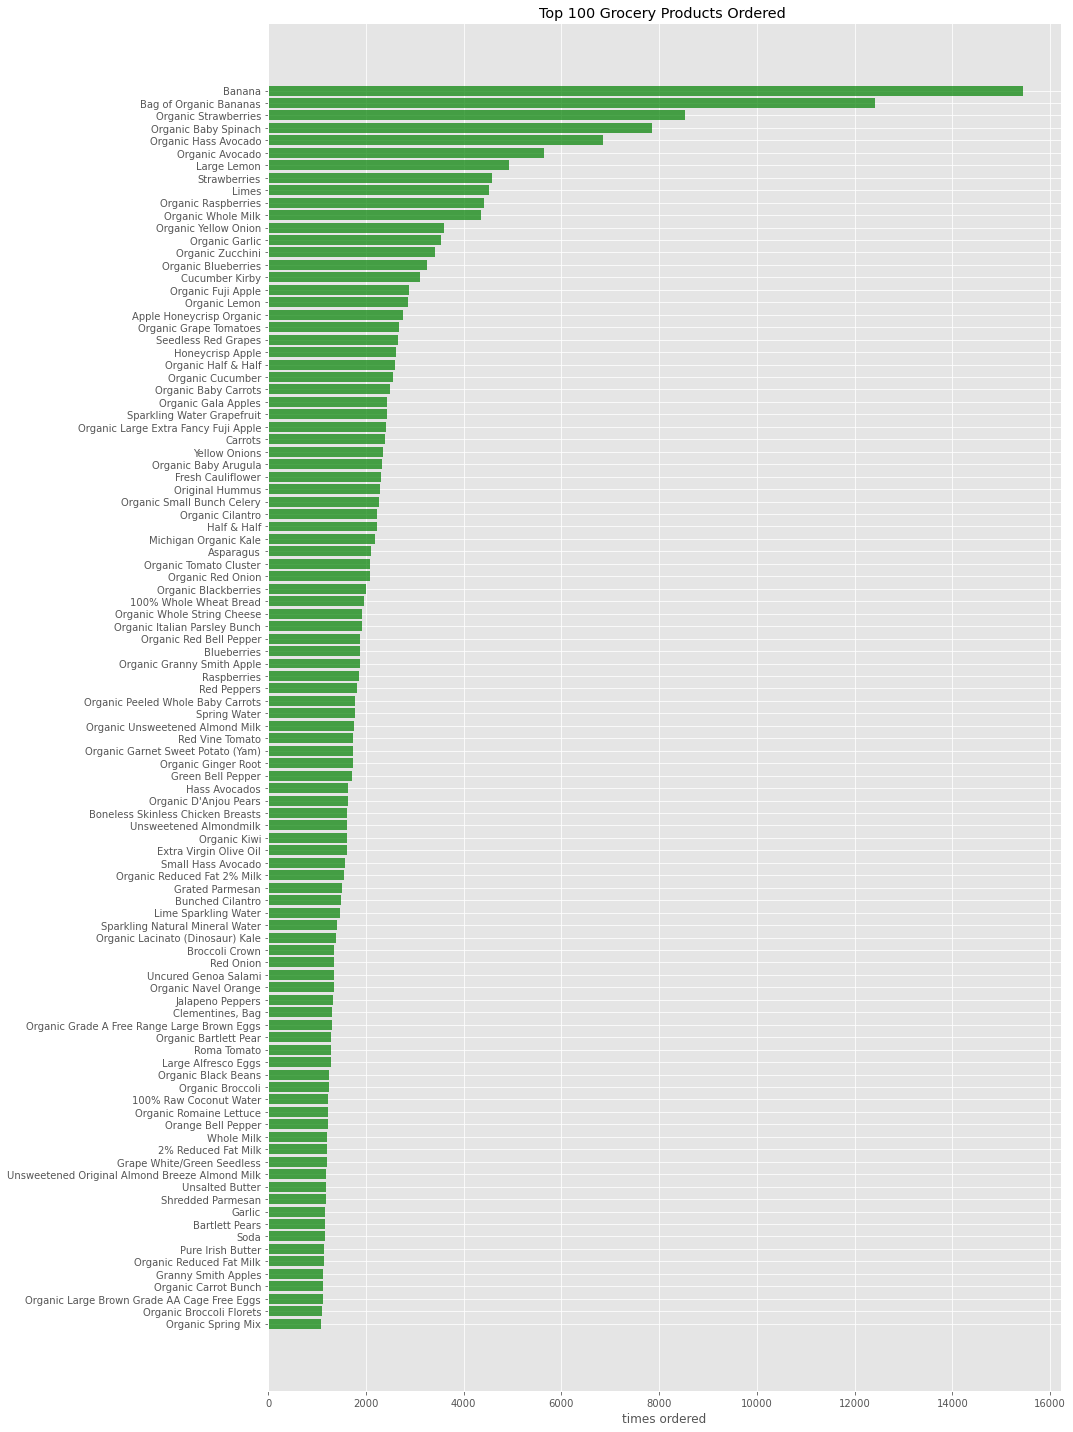

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_products['product_name'], top_100_products['times_ordered'], color='g', alpha=0.7)
ax.set_title('Top 100 Grocery Products Ordered ')
ax.set_xlabel('times ordered')
plt.tight_layout();

Wow, produce - especially fruit - is *dominating* the top grocery products here. Bananas alone are in their own category. There are also plenty of dairy products, a couple bread items, and some sparkling waters here. In any case, I suppose it's no wonder that the produce section has a decent amount of real estate to itself in a store. 

### Looking into the products' departments

Speaking of gorcery departments, let's see how all prior orders break down by department and whether produce is in fact the top seller:

In [25]:
product_orders_by_dept = product_info_df.groupby(['dept_name']).sum('times_ordered').sort_values('times_ordered')
product_orders_by_dept.drop(['product_id', 'department_id', 'aisle_id'], axis=1, inplace=True)
product_orders_by_dept

,times_ordered
dept_name,
bulk,1133
other,1180
pets,3306
alcohol,4856
international,8778
babies,13775
personal care,14577
meat seafood,22958
breakfast,23007


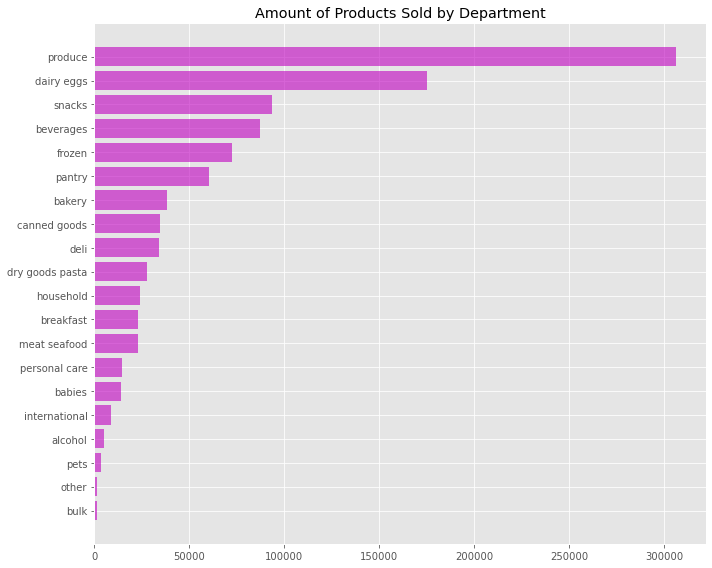

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(product_orders_by_dept.index, product_orders_by_dept['times_ordered'], color='m', alpha=0.6)
ax.set_title('Amount of Products Sold by Department')
plt.tight_layout();

This seems to more-or-less align with our top 100 products, although I didn't expect snacks to make such a strong showing. However, let's make sure we're comparing apples-to-apples (grocery pun!) and look at the size of these departments (in this case, 'size' is measured by the variety of products):

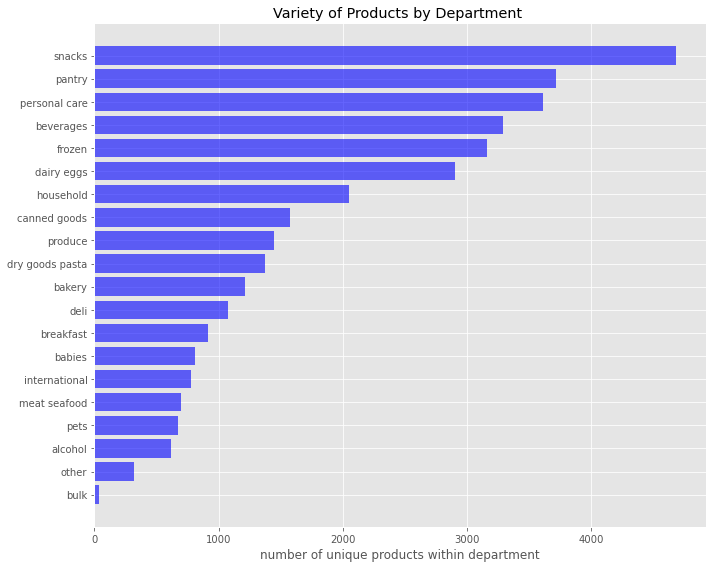

In [27]:
product_variety_by_dept = product_info_df.groupby(['dept_name']).size().sort_values()

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(product_variety_by_dept.index, product_variety_by_dept.values, color='b', alpha=0.6)
ax.set_title('Variety of Products by Department ')
ax.set_xlabel('number of unique products within department')
plt.tight_layout();

Interesting to see how far down the produce department is on the variety of its products while maintaining the top spot in number of products sold. Conversely, the pantry department has the second-highest variety count, yet comes in sixth place with products sold.

### Exploring the aisles table

Now that we have an overall picture of product and department popularity to keep in mind as we move forward, let's also explore how the aisles relate. Since Instacart - as a grocery *retrieval service*, not a grocer - would want to optimize its workers' shopping trips, aisle order and/or position may be important. The provided 'aisles' table might represent a specific store or a generalized aisle layout or sequence. 

It may be the latter since, as seen previously, there are 134 aisles listed in that table and that seems much larger than even a large grocery store. Additionally, Instacart is likely interested in a broader look at their order data beyond that of a single store. 

In [28]:
product_info_df.head()

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
0,24852,15450,Banana,4,produce,24,fresh fruits
1,13176,12409,Bag of Organic Bananas,4,produce,24,fresh fruits
2,21137,8528,Organic Strawberries,4,produce,24,fresh fruits
3,21903,7852,Organic Baby Spinach,4,produce,123,packaged vegetables fruits
4,47209,6857,Organic Hass Avocado,4,produce,24,fresh fruits


In [29]:
product_orders_by_aisle = product_info_df.loc[:, ['aisle_id', 'aisle_name', 'dept_name', 'times_ordered']]
product_orders_by_aisle.head()

,aisle_id,aisle_name,dept_name,times_ordered
0,24,fresh fruits,produce,15450
1,24,fresh fruits,produce,12409
2,24,fresh fruits,produce,8528
3,123,packaged vegetables fruits,produce,7852
4,24,fresh fruits,produce,6857


In [30]:
product_orders_by_aisle.groupby(['aisle_id', 'aisle_name']).sum('times_ordered').sort_values('aisle_id')

,,times_ordered
aisle_id,aisle_name,
1,prepared soups salads,2372
2,specialty cheeses,2718
3,energy granola bars,14811
4,instant foods,6380
5,marinades meat preparation,1935
...,...,...
130,hot cereal pancake mixes,5244
131,dry pasta,8547
132,beauty,174


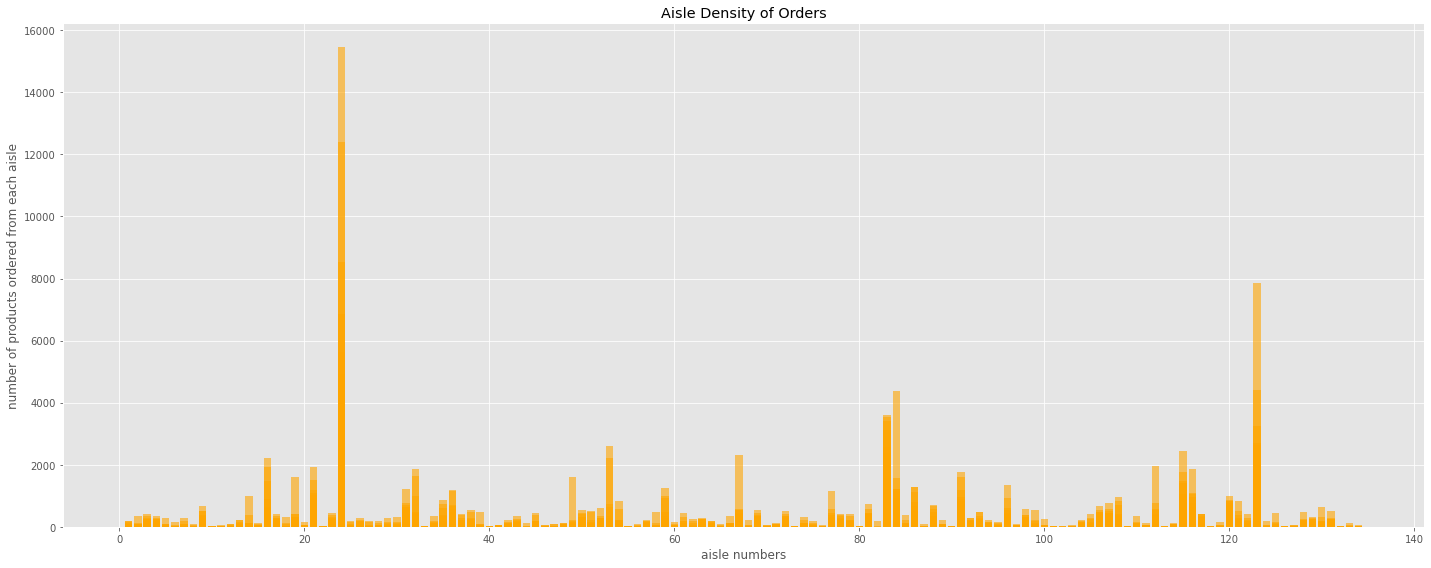

In [31]:
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(product_orders_by_aisle['aisle_id'], product_orders_by_aisle['times_ordered'], color='orange', alpha=0.6)
ax.set_title('Aisle Density of Orders')
ax.set_xlabel('aisle numbers')
ax.set_ylabel('number of products ordered from each aisle')
plt.tight_layout();

Assuming a more-or-less straight-line path through the store, Instacart shoppers may encounter quite the busy 24th aisle, but the rest are likely managable except for a few more dense aisles along the way. 

Of course, we know stores aren't laid out this way. There's usually an entire produce section, a 'meat market' section with butcher and deli counters (neither of which have an assigned 'aisle number'), a bakery section/counter, and likely a large variety of layouts for numbered aisles. Some stores are smaller and barely sell anything that isn't a food product, while others have clothing aisles and you can even buy a truck at Costco. Ultimately, this graph likely doesn't inform Instacart's bottom line. 

However, taking this perspective may prove useful to grocery stores when setting up new stores or reorganizing existing layouts. It has doubtlessly been accounted for and may be part of the reason why produce has its own 'section' where the (often unnumbered) 'aisles' are wider. The popularity of the 'dairy egg' department may pe part of the reason that [milk is usually found towards the back of the store.](https://www.tasteofhome.com/article/the-real-reason-your-grocery-store-milk-gets-put-in-the-back/#:~:text=It%20turns%20out%20that%20supermarkets,to%20food%20writer%20Michael%20Pollan.)

### Looking into which products are reordered more often

In any case, we've been looking at products in general so far. Let's also explore the provided data on which products tend to be reordered the most as well as when these orders tend to be placed.

In [32]:
product_reorders_df = pd.read_sql(
                        """SELECT
                                opp.product_id,
                                p.product_name,
                                COUNT(opp.product_id) AS times_ordered,
                                SUM(opp.reordered) as times_reordered, 
                                AVG(opp.add_to_cart_order) AS avg_place_in_added_to_cart_sequence,
                                d.department AS dept_name
                            FROM order_products__prior AS opp
                            JOIN products AS p
                                USING(product_id)
                            JOIN departments AS d
                                USING(department_id)
                            GROUP BY product_id
                            ORDER BY times_reordered DESC;
                        """, conn)
product_reorders_df

,product_id,product_name,times_ordered,times_reordered,avg_place_in_added_to_cart_sequence,dept_name
0,24852,Banana,15450,13024,4.895793,produce
1,13176,Bag of Organic Bananas,12409,10297,5.114433,produce
2,21137,Organic Strawberries,8528,6603,7.173194,produce
3,21903,Organic Baby Spinach,7852,6093,7.389455,produce
4,47209,Organic Hass Avocado,6857,5435,6.815663,produce
...,...,...,...,...,...,...
35444,38,Ultra Antibacterial Dish Liquid,1,0,12.000000,missing
35445,19,Gluten Free Quinoa Three Cheese & Mushroom Blend,1,0,21.000000,dry goods pasta
35446,14,Fresh Scent Dishwasher Cleaner,2,0,9.500000,household
35447,8,Cut Russet Potatoes Steam N' Mash,2,0,9.500000,frozen


In [33]:
#Reapplying the missing department records from before (aisles don't seem as pertinent any longer):
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'

#Then dropping the remaining missing departments:
product_reorders_df = product_reorders_df[product_reorders_df['dept_name'] != 'missing']

In [34]:
product_reorders_df['percentage_as_a_reorder'] = product_reorders_df['times_reordered'] / product_reorders_df['times_ordered']
product_reorders_df.head()

,product_id,product_name,times_ordered,times_reordered,avg_place_in_added_to_cart_sequence,dept_name,percentage_as_a_reorder
0,24852,Banana,15450,13024,4.895793,produce,0.842977
1,13176,Bag of Organic Bananas,12409,10297,5.114433,produce,0.829801
2,21137,Organic Strawberries,8528,6603,7.173194,produce,0.774273
3,21903,Organic Baby Spinach,7852,6093,7.389455,produce,0.775981
4,47209,Organic Hass Avocado,6857,5435,6.815663,produce,0.792621


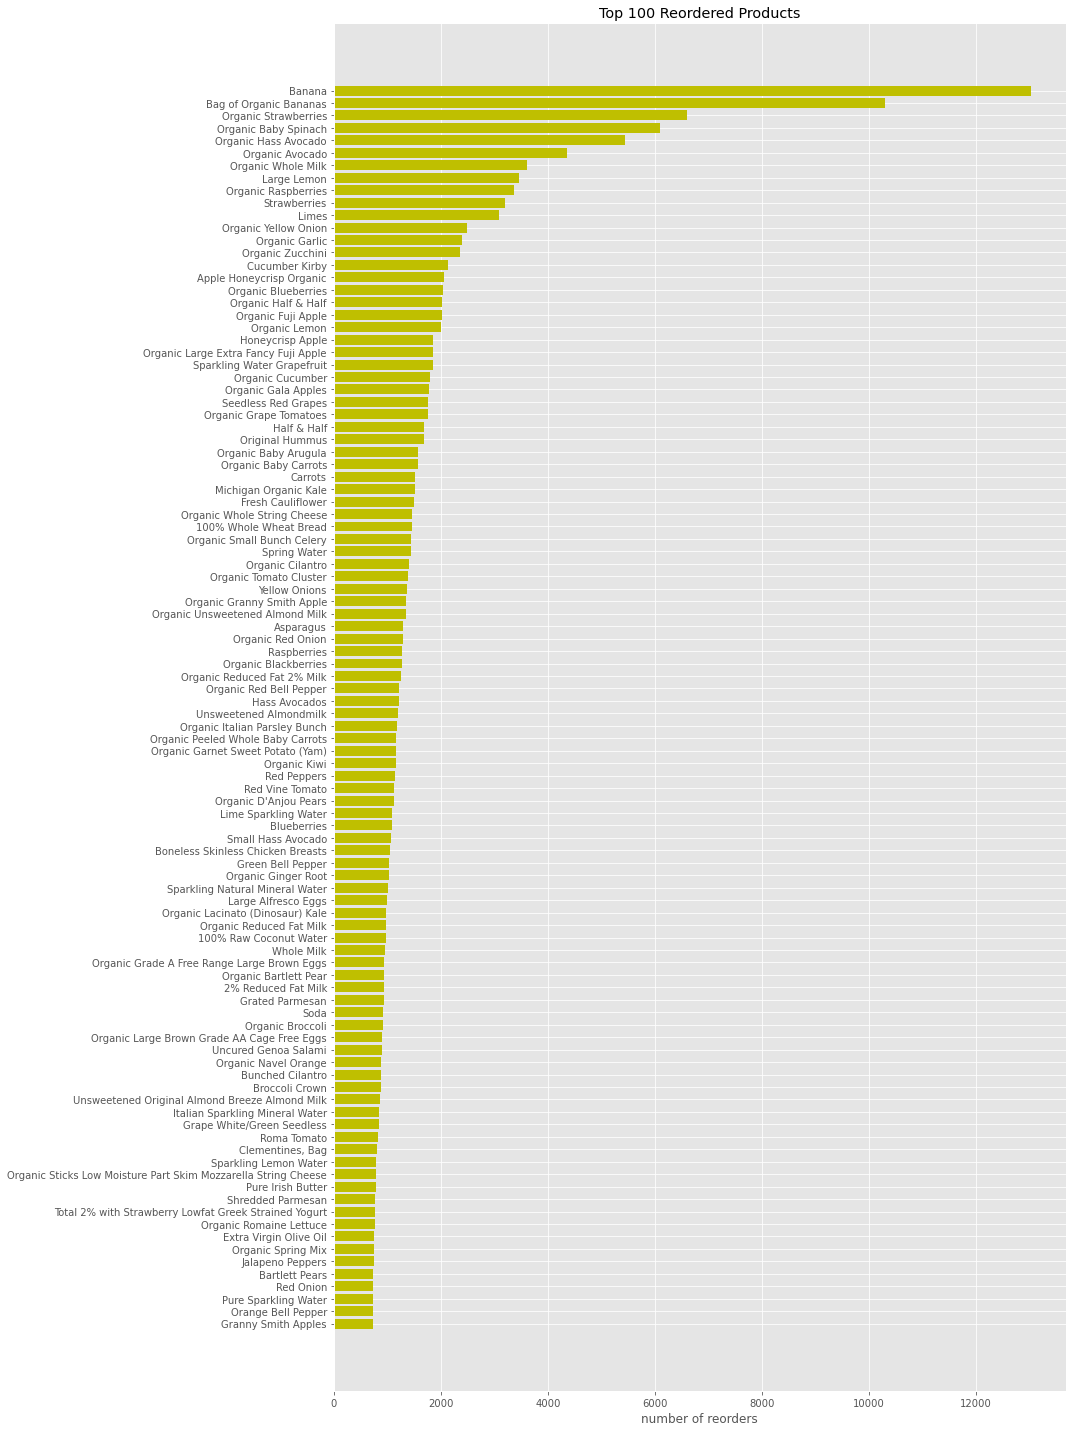

In [35]:
top_100_reorders = product_reorders_df[0:100].sort_values('times_reordered')

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_reorders['product_name'], top_100_reorders['times_reordered'], color='y')
ax.set_title('Top 100 Reordered Products')
ax.set_xlabel('number of reorders')
plt.tight_layout();

We see many similarities with the top 100 overall products. What if we looked at the *percentage* of product orders that are reorders instead of just the overall count?

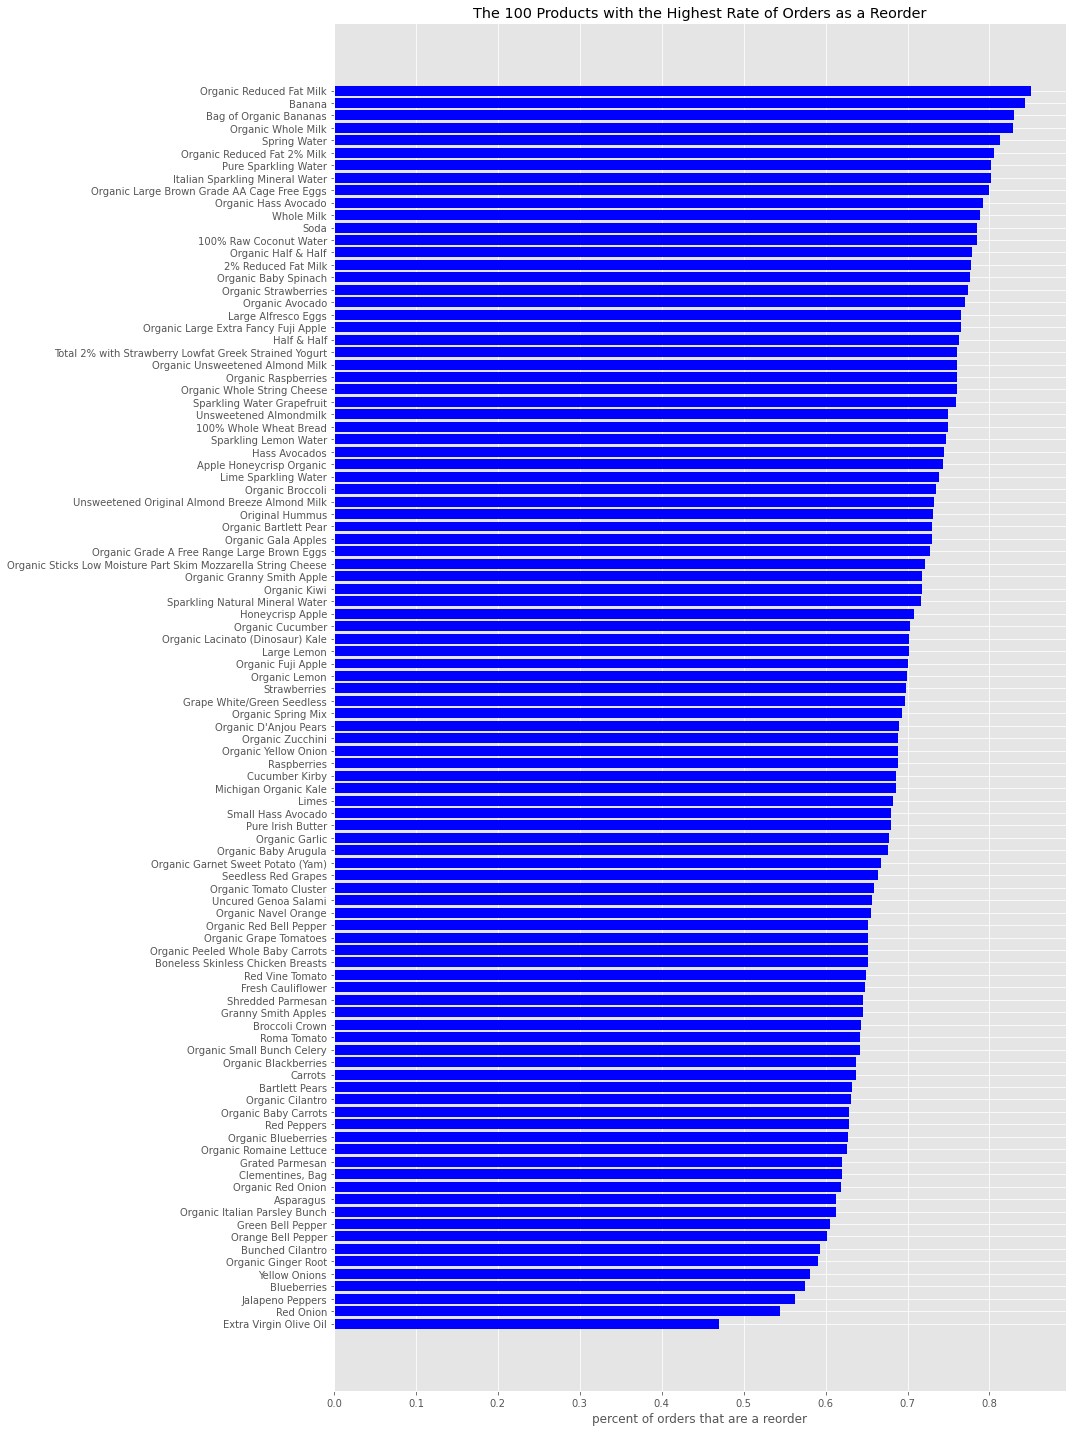

In [36]:
top_100_reorders_percentages = product_reorders_df[0:100].sort_values('percentage_as_a_reorder')

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_reorders_percentages['product_name'], top_100_reorders_percentages['percentage_as_a_reorder'], color='b')
ax.set_title('The 100 Products with the Highest Rate of Orders as a Reorder')
ax.set_xlabel('percent of orders that are a reorder')
plt.tight_layout();

There's an interesting resurgance of the 'diary egg' department percentage-wise here. Let's nail down some specifics for departments when it comes to both reorder counts and percentages. The table below is ordered by highest reorder percentages:

In [37]:
dept_reorders_by_count = product_reorders_df.groupby('dept_name')['times_reordered'].sum()
dept_reorders_by_percent = product_reorders_df.groupby('dept_name')['percentage_as_a_reorder'].mean()

dept_reorders_df = pd.DataFrame(columns = ['dept_reorders_by_count', 'dept_reorders_by_percent'])
dept_reorders_df['dept_reorders_by_count'] = dept_reorders_by_count
dept_reorders_df['dept_reorders_by_percent'] = dept_reorders_by_percent
dept_reorders_df['no_of_unique_products'] = product_variety_by_dept

dept_reorders_df.sort_values('dept_reorders_by_percent', ascending=False)

,dept_reorders_by_count,dept_reorders_by_percent,no_of_unique_products
dept_name,,,
pets,2071,0.590717,670
dairy eggs,117336,0.538598,2907
bakery,24220,0.524813,1215
beverages,56714,0.517102,3294
deli,20630,0.493651,1074
snacks,53943,0.485326,4688
breakfast,12881,0.478369,912
babies,8021,0.474626,810
bulk,659,0.467972,34


Interestingly enough, 'dairy eggs' has the second-highest percentage of orders that are reorders (53.9%) whereas produce is in the middle of the pack at 44.8%. However, it's worth noting that 'dairy eggs' has about twice as many different products than produce. Nonetheless, this suggests that dairy and egg product orders may be more consistent mainstays than produce products;  while produce is ordered more often, the individual produce products may vary more from one order to the next. 

It also seems noteworthy that the 'pets' department has the highest reorder percentage by far. I suppose pet owners know what their animals need and less in the way of variety is needed. Dairy, baked goods, and beverages also seem to cluster somewhat closely as more mainstay-oriented departments. 

**Next up is exploring the add_to_cart_order, the d.o.w. and t.o.d. data, and then (1) bring it all together to make a point about predicting future orders or (2) starting in on the linear regression aspect with these features and trying to see which one(s) have the biggest influence on (reorders by percent as the target, maybe?) and only *then* predicting future order information. We may *also* want to consider some more aisle considerations for grocery store applications beyond the Instacart-friendly ideas.**

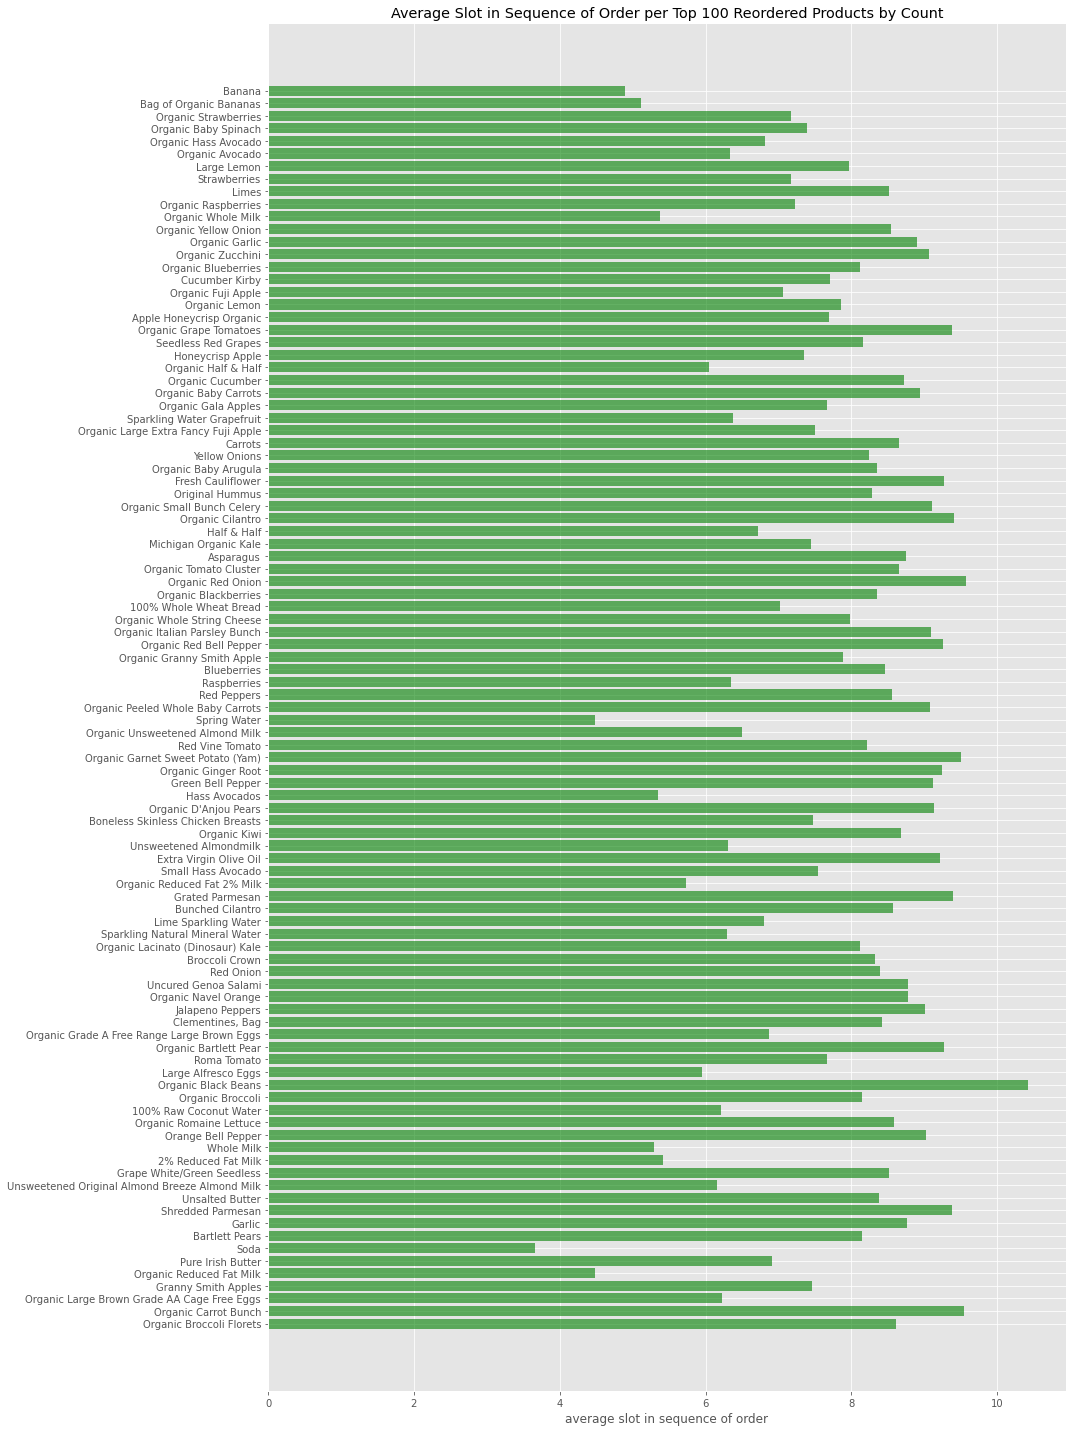

In [38]:
#Maybe we'll start this add-to-cart stuff with the top_100_reorders_by_count with an average add-to-cart-order and then
# line plot that.
top_100_reorders_by_count = product_reorders_df.sort_values('times_ordered', ascending=False)
top_100_reorders_by_count = top_100_reorders_by_count[0:99]
#Reordering it for the graph:
top_100_reorders_by_count = top_100_reorders_by_count.iloc[::-1]

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_reorders_by_count['product_name'], top_100_reorders_by_count['avg_place_in_added_to_cart_sequence'], color='g', alpha=0.6)
ax.set_title('Average Slot in Sequence of Order per Top 100 Reordered Products by Count')
ax.set_xlabel('average slot in sequence of order')
plt.tight_layout();

Reordering a product and its place in the sequence of being added to the cart do not appear to be strongly correlated. Let's take another look at this top_100_reorders_by_count df:

In [39]:
#Undoing the previous reordering for the graph:
top_100_reorders_by_count = top_100_reorders_by_count.iloc[::-1]
top_100_reorders_by_count.head(10)

,product_id,product_name,times_ordered,times_reordered,avg_place_in_added_to_cart_sequence,dept_name,percentage_as_a_reorder
0,24852,Banana,15450,13024,4.895793,produce,0.842977
1,13176,Bag of Organic Bananas,12409,10297,5.114433,produce,0.829801
2,21137,Organic Strawberries,8528,6603,7.173194,produce,0.774273
3,21903,Organic Baby Spinach,7852,6093,7.389455,produce,0.775981
4,47209,Organic Hass Avocado,6857,5435,6.815663,produce,0.792621
5,47766,Organic Avocado,5646,4349,6.332625,produce,0.770280
7,47626,Large Lemon,4928,3456,7.961445,produce,0.701299
9,16797,Strawberries,4587,3204,7.163942,produce,0.698496
10,26209,Limes,4526,3086,8.514361,produce,0.681838
8,27966,Organic Raspberries,4420,3361,7.231900,produce,0.760407


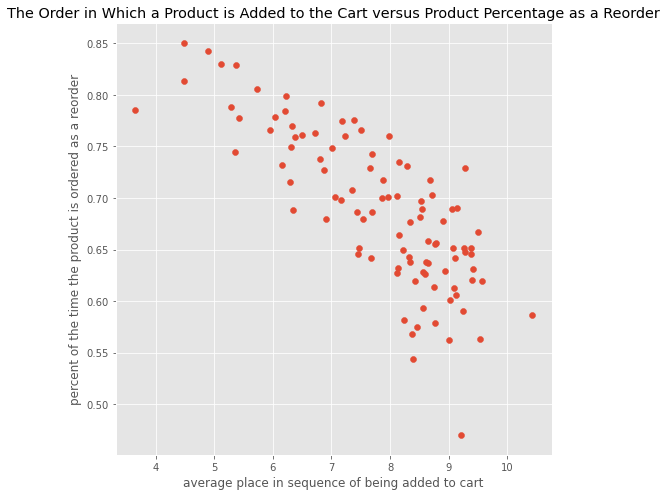

In [40]:
#How about the add-to-cart orders versus their percentage-likelihood-to-be-a-reorder?
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(top_100_reorders_by_count['avg_place_in_added_to_cart_sequence'], top_100_reorders_by_count['percentage_as_a_reorder'])
ax.set_title("The Order in Which a Product is Added to the Cart versus Product Percentage as a Reorder")
ax.set_ylabel('percent of the time the product is ordered as a reorder')
ax.set_xlabel('average place in sequence of being added to cart')
plt.tight_layout();

There's an apparent negative correlation here: the more likely a product is to be a reorder, the earlier it appears in the cart during the order.

This was the top 100, though. We don't need to limit the number of it we're looking at a broader trend, so let's redo this with the whole scope of products:

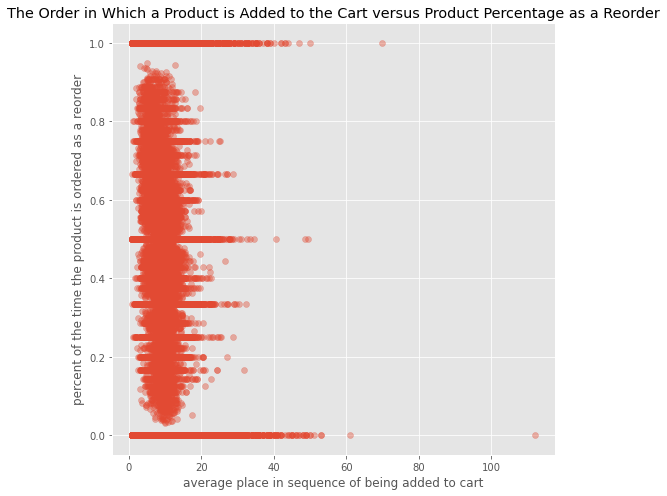

In [41]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(product_reorders_df['avg_place_in_added_to_cart_sequence'], product_reorders_df['percentage_as_a_reorder'], alpha=0.4)
ax.set_title("The Order in Which a Product is Added to the Cart versus Product Percentage as a Reorder")
ax.set_ylabel('percent of the time the product is ordered as a reorder')
ax.set_xlabel('average place in sequence of being added to cart')
plt.tight_layout();

Ok nevermind, that's a mess. It looks like percentages accumulate in certain places and some outliers make it hard to spot a correlation. Let's just make it the top 1,000 reordered products and see what we find:

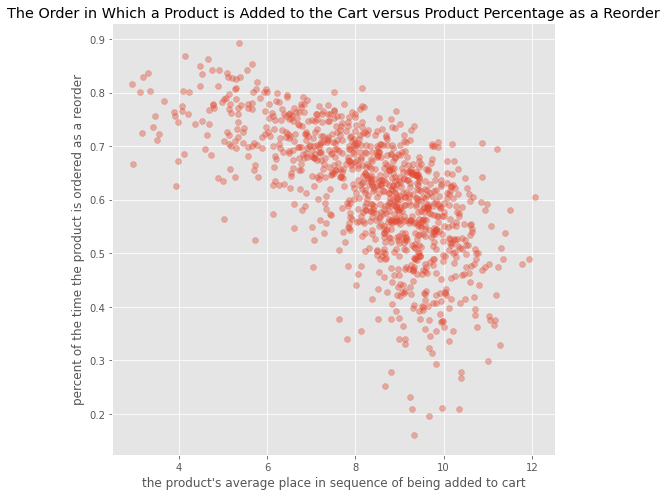

In [42]:
top_1000_reorders_by_count = product_reorders_df.sort_values('times_ordered', ascending=False)
top_1000_reorders_by_count = top_1000_reorders_by_count[0:999]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(top_1000_reorders_by_count['avg_place_in_added_to_cart_sequence'], top_1000_reorders_by_count['percentage_as_a_reorder'], alpha=0.4)
ax.set_title("The Order in Which a Product is Added to the Cart versus Product Percentage as a Reorder")
ax.set_ylabel("percent of the time the product is ordered as a reorder")
ax.set_xlabel("the product's average place in sequence of being added to cart")
plt.tight_layout();

It looks like a similar trend with the top 100 reordered products, but it's taking a curved shape rather than a seemingly straight line now that we're looking at more products. **This is a good place for l.r. to come in. Maybe we even already saw a few other places along the way.**

Anyway, is it even worth it to look at department stuff in the added-to-cart-sequence? Does that have anything to do with anything? I suppose if Instacart is looking to predict future orders...they're probably going to be more concerned with products than departments, right? I think even a grocer wouldn't care becuase they already know which departments are mainstays, so yeah, let's disregard departments and add-to-cart-sequences.

In [43]:
#product_reorders_by_dept = product_reorders_df.groupby('department').mean('add_to_cart_order')
#product_reorders_by_dept = product_reorders_df.groupby('department')['add_to_cart_order'].mean().sort_values(ascending=False)
#product_reorders_by_dept

It is decided that we will progress to the perspective of time upon the placement of Instacart orders.

In [44]:
order_times_df = pd.read_sql(
                    """SELECT
                            products.product_id,
                            products.product_name,
                            orders.order_number,
                            orders.order_dow AS day_of_week,
                            orders.order_hour_of_day,
                            orders.days_since_prior_order,
                            departments.department AS dept_name,
                            aisles.aisle AS aisle_name
                        FROM aisles
                        JOIN products 
                            USING(aisle_id)
                        JOIN departments
                            USING(department_id)
                        JOIN order_products__prior
                            USING(product_id)
                        JOIN orders
                            USING(order_id);
                    """, conn)
order_times_df

,product_id,product_name,order_number,day_of_week,order_hour_of_day,days_since_prior_order,dept_name,aisle_name
0,209,Italian Pasta Salad,26,0,20,1.0,deli,prepared soups salads
1,554,Turkey Chili,12,0,20,4.0,deli,prepared soups salads
2,554,Turkey Chili,2,4,10,1.0,deli,prepared soups salads
3,554,Turkey Chili,7,6,13,6.0,deli,prepared soups salads
4,554,Turkey Chili,45,3,5,4.0,deli,prepared soups salads
...,...,...,...,...,...,...,...,...
1048570,47713,Sparkling Rose,2,4,8,14.0,alcohol,specialty wines champagnes
1048571,47713,Sparkling Rose,2,6,17,6.0,alcohol,specialty wines champagnes
1048572,48984,Dry Sherry,1,4,21,NaN,alcohol,specialty wines champagnes
1048573,48984,Dry Sherry,15,1,19,1.0,alcohol,specialty wines champagnes


In [45]:
order_times_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   product_id              1048575 non-null  int64  
 1   product_name            1048575 non-null  object 
 2   order_number            1048575 non-null  int64  
 3   day_of_week             1048575 non-null  int64  
 4   order_hour_of_day       1048575 non-null  int64  
 5   days_since_prior_order  981545 non-null   float64
 6   dept_name               1048575 non-null  object 
 7   aisle_name              1048575 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 64.0+ MB


Looks like we have some NaN's in the days_since_prior_order column; are they zeroes?

In [46]:
order_times_df['days_since_prior_order'].value_counts()

7.0     112256
30.0     96293
6.0      82568
5.0      68708
4.0      66108
8.0      61782
3.0      61738
2.0      48195
9.0      40523
14.0     34081
10.0     32751
1.0      29976
11.0     27484
13.0     26960
12.0     24864
15.0     21951
16.0     14703
0.0      14443
21.0     13607
17.0     12408
20.0     12280
19.0     11805
18.0     10998
22.0      9384
28.0      8178
23.0      7190
27.0      6476
24.0      6355
25.0      5901
29.0      5897
26.0      5682
Name: days_since_prior_order, dtype: int64

In [47]:
order_times_df['days_since_prior_order'].isna().sum()

67030

It turns out the null 'days_since_prior_order' values here are not placeholders for '0' days as we see in the value_counts above. They actually represent data from the last orders customers made before this dataset snapshot was taken back in 2017. A lot of the data from those records were removed and put into a train-test split for an [Instacart Kaggle competition](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data). Contestants trying to predict future orders trained on the 'order_products__prior' table, tested on the train, but Instacart's team scored contestnats on the test set they kept. 

I'm using this dataset much later, so for my purposes I'll just stick with the order_products__prior. I don't think I need to drop the records containing those NaNs so much as keep them in mind once I start working with days_since_prior_order.

In any case, let's begin looking through these order times by isolating the day of the week:

In [48]:
order_times_df['day_of_week'].value_counts()

0    200157
1    182577
6    146549
2    138111
5    135534
3    124116
4    121531
Name: day_of_week, dtype: int64

I'm not sure which day of the week corresponds to 0 and I'm not finding any answers from Instacart's Kaggle data description. I think '0' would typically be Sunday since it's the first day of the week, but my guess is it's Saturday here since '0' and '1' have the most orders by far. Looking online, it seems like [people definitely shop most often on Saturday, then Sunday, then there's a big dropoff to Monday](https://www.creditdonkey.com/grocery-shopping-statistics.html#:~:text=What%20day%20of%20the%20week%20is%20the,Saturdays%20are%20prime%20time%20for%20grocery%20shoppers.), which would correspond with assiging '0' to Saturday here.

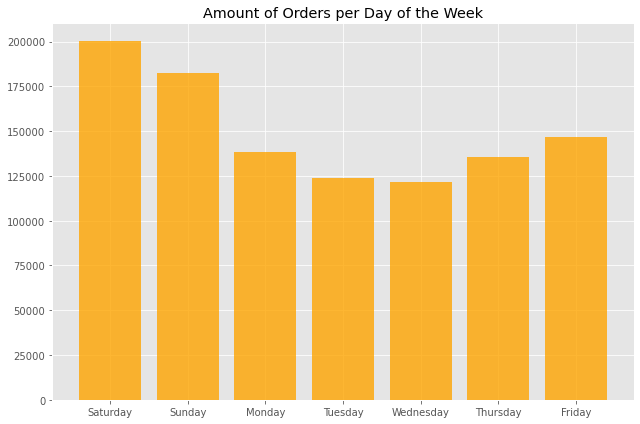

In [49]:
#Grouping the order_times_df
orders_by_dow = order_times_df.groupby('day_of_week').count()
orders_by_dow.reset_index(inplace=True)

#Replacing the numeric day of the week values
day_of_week_dict = {0: 'Saturday', 1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 
                    4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}
orders_by_dow['day_of_week'].replace(day_of_week_dict, inplace=True)

#Plotting
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(orders_by_dow['day_of_week'], orders_by_dow['product_id'], color='orange', alpha=0.8)
ax.set_title("Amount of Orders per Day of the Week")
plt.tight_layout();

Folks tear it up on the weekend while Wednesday is the nadir of shopping. I wonder whether grocery stores do more restocking, cleaning, or other administrative stuff on those days. Maybe Tuesday and Wednesday make up the grocers' "weekend". Anyway, there's definitely a "ramp-up" to the weekend that begins on Thursday.

**WELP, I guess it's time to do the same thing for hours of the week. Remember, these are very big-picture perspectives. Maybe we'll find some interesting correlations among departments and even within those departments like the Instacart folks show [here](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) with somewhat healthier versus less-healthy foods.**

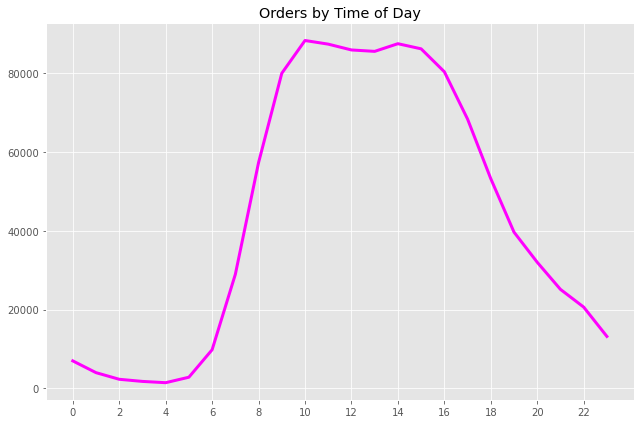

In [50]:
#Grouping the order_times_df
orders_by_hod = order_times_df.groupby('order_hour_of_day').count()
#orders_by_hod.reset_index(inplace=True)

#Plotting
import numpy as np
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(orders_by_hod.index, orders_by_hod['product_id'], color='magenta', lw=3)
ax.set_title("Orders by Time of Day")
plt.xticks(ticks=np.arange(0,24,2))
plt.tight_layout();

Orders seem to remain pretty consistent between 10am-3pm before falling off for the night. It'd be interesting to have data on turn-around time for these orders, but either way, grocery-ordering seems to be a pretty diurnal phenomenon.

The last of the big-picture time perspectives offered here is the amount of days since the last order. 

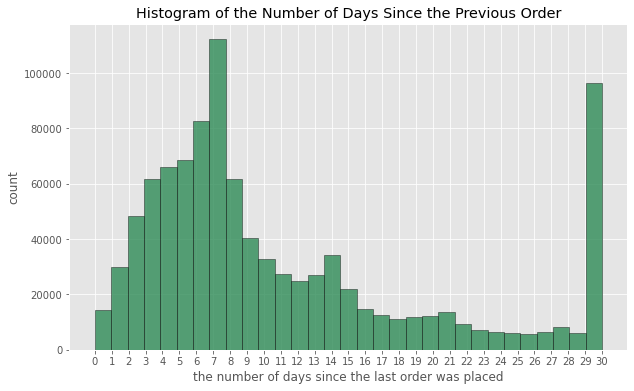

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(order_times_df['days_since_prior_order'], bins=31, color='seagreen', edgecolor='k', alpha=0.8)
plt.xticks(ticks=np.arange(0,31,1))
ax.set_title('Histogram of the Number of Days Since the Previous Order')
ax.set_xlabel('the number of days since the last order was placed')
ax.set_ylabel('count');

Most customers order once a week with a surpising amount ordering even more often. Maybe this reflects a population in a dense urban area where people tend to shop more often for fewer items than one larger trip a week. There are peaks every seven days for those shopping every two, three, or four weeks. Do some people really only order grocieris once a month? Finally, it's likely that '30' also represents '30 or more' days; there may be a lot of customers who mostly shop on their own and only use Instacart occasionally.

Let's take a deeper look into these temporal aspects 🤓 with departments or who cares no wait, I'm supposed to care:

In [52]:
#Reapplying the missing department & aisle records from before:
order_times_df.loc[order_times_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
order_times_df.loc[order_times_df['product_name'] == 'Organic Riced Cauliflower', 'aisle_name'] = 'fresh vegetables'

order_times_df.loc[order_times_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
order_times_df.loc[order_times_df['product_name'] == 'Organic Mango Yogurt', 'aisle_name'] = 'yogurt'

order_times_df.loc[order_times_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
order_times_df.loc[order_times_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'aisle_name'] = 'ice cream ice'

order_times_df.loc[order_times_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
order_times_df.loc[order_times_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'

order_times_df.loc[order_times_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'
order_times_df.loc[order_times_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'aisle_name'] = 'yogurt'
#The dropping the remaining missing departments:
order_times_df = order_times_df[order_times_df['dept_name'] != 'missing']

In [53]:
order_times_df.head(3)

,product_id,product_name,order_number,day_of_week,order_hour_of_day,days_since_prior_order,dept_name,aisle_name
0,209,Italian Pasta Salad,26,0,20,1.0,deli,prepared soups salads
1,554,Turkey Chili,12,0,20,4.0,deli,prepared soups salads
2,554,Turkey Chili,2,4,10,1.0,deli,prepared soups salads


In [54]:
#order_times_by_dept = order_times_df.groupby('dept_name')['days_since_prior_order'].mean()
#Not interesting.
order_times_by_aisle = order_times_df.groupby('aisle_name')['order_hour_of_day'].mean().sort_values(ascending=False)
order_times_by_aisle 

aisle_name
red wines                  14.009786
ice cream ice              13.990020
fresh pasta                13.831431
shave needs                13.830409
frozen vegan vegetarian    13.829991
                             ...    
cold flu allergy           12.980392
cleaning products          12.948982
tea                        12.939361
trail mix snack mix        12.805695
mint gum                   12.712912
Name: order_hour_of_day, Length: 134, dtype: float64

In [55]:
round(order_times_by_aisle.min(), 1), round(order_times_by_aisle.max(),1)
#Not a ton of difference here, but I suppose that goes back to how many more orders are placed
# between 10am-3pm as well as the fact that these aisles are just a part of a larger order.

(12.7, 14.0)

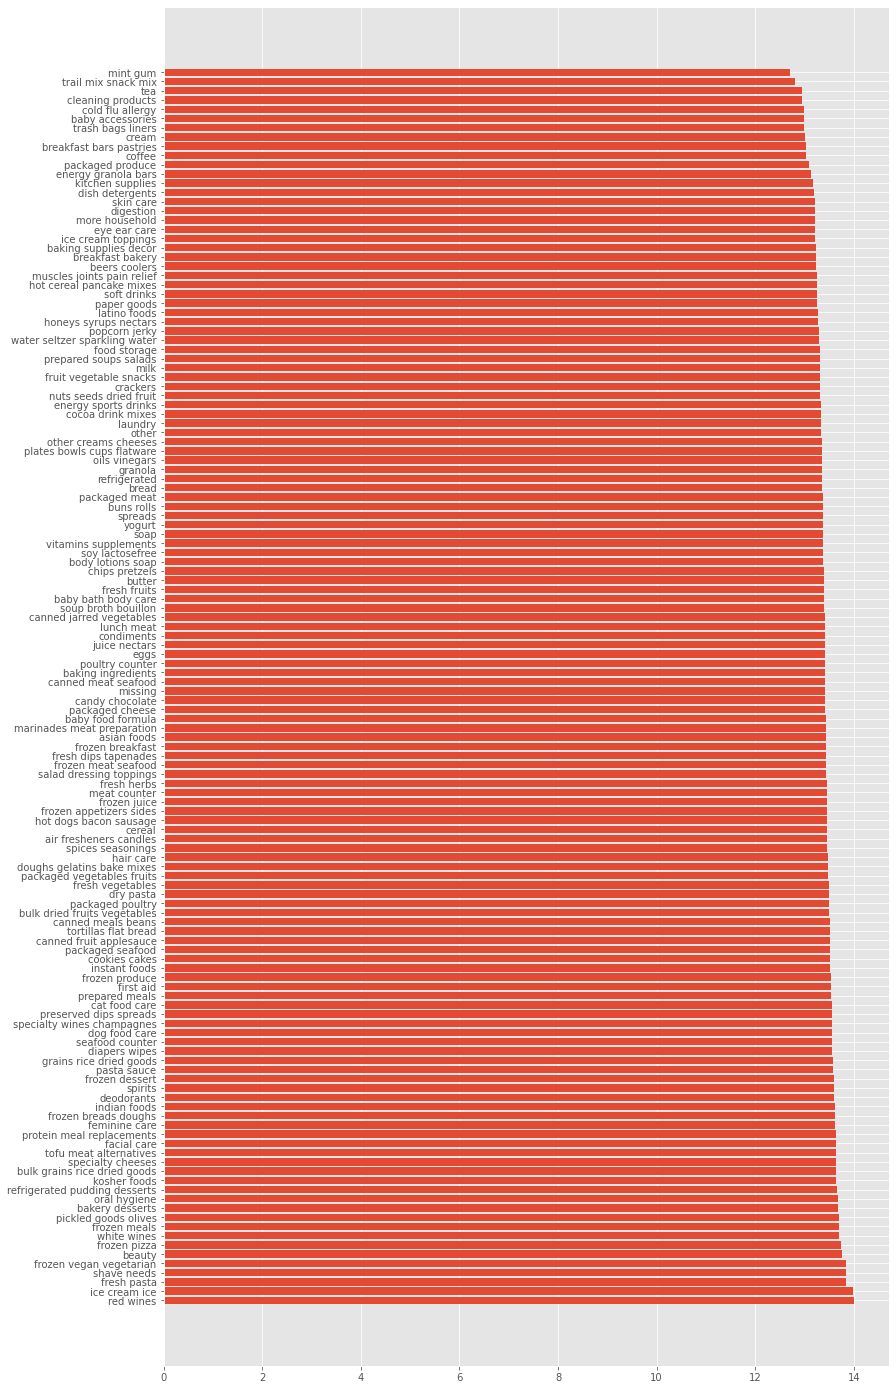

In [56]:
fig, ax = plt.subplots(figsize=(13,25))
ax.barh(order_times_by_aisle.index, order_times_by_aisle.values);

Even though there doesn't seem to be a large *overall* difference among aisles and the time of day, it is interesting to see how the aisles with the earliest-ordered products include household cleaning items, breakfast products, medicine, and "baby accessories." Meanwhile, the latest-ordered aisles involve more in the way of desserts, alcohol, frozen goods, and carbohydrates along with the somewhat puzzling inclusion of beauty products and "shave needs".

I wonder how these look when plotted together:

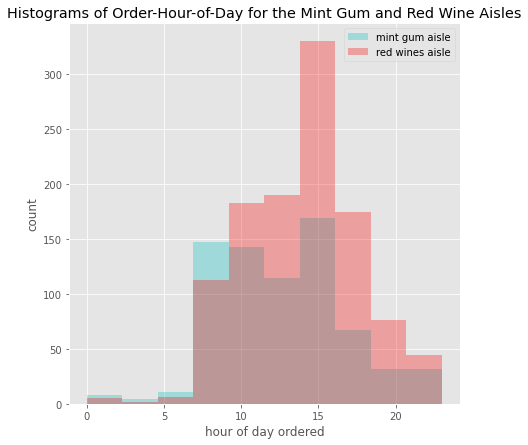

In [57]:
mint_gum_aisle = order_times_df[order_times_df['aisle_name'] == 'mint gum']
mint_gum_aisle_ohod = mint_gum_aisle['order_hour_of_day']
red_wines_aisle = order_times_df[order_times_df['aisle_name'] == 'red wines']
red_wines_aisle_ohod = red_wines_aisle['order_hour_of_day']

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(mint_gum_aisle_ohod, color='c', alpha=0.3, label='mint gum aisle')
ax.hist(red_wines_aisle_ohod, color='r', alpha=0.3, label='red wines aisle')
ax.set_title('Histograms of Order-Hour-of-Day for the Mint Gum and Red Wine Aisles')
ax.set_xlabel('hour of day ordered')
ax.set_ylabel('count')
plt.legend();

These two aisles differ by volume and also seem to have a different distribution of order-hour-of-day, so they don't make the best comparison. In any case, the time of day may make a slight difference in what Instacart can expect to see ordered, but it doesn't appear to be an esepcially compelling factor. 

What about aisles and days since prior order?

In [58]:
dspo_by_aisle = order_times_df.groupby('aisle_name')['days_since_prior_order'].mean().sort_values(ascending=False)
dspo_by_aisle 

aisle_name
facial care                     14.519444
shave needs                     13.977636
eye ear care                    13.563636
first aid                       13.296029
body lotions soap               12.759056
                                  ...    
spirits                         10.048285
bulk dried fruits vegetables     9.955017
baby food formula                9.935853
specialty wines champagnes       9.718563
vitamins supplements             9.462244
Name: days_since_prior_order, Length: 134, dtype: float64

In [59]:
round(dspo_by_aisle.min(),1), round(dspo_by_aisle.max(),1)
#Bigger difference among aisles here, from 9.5 days since the order minimum average
# for vitamins/supplements and 14.5 days maximum average for facial care.

(9.5, 14.5)

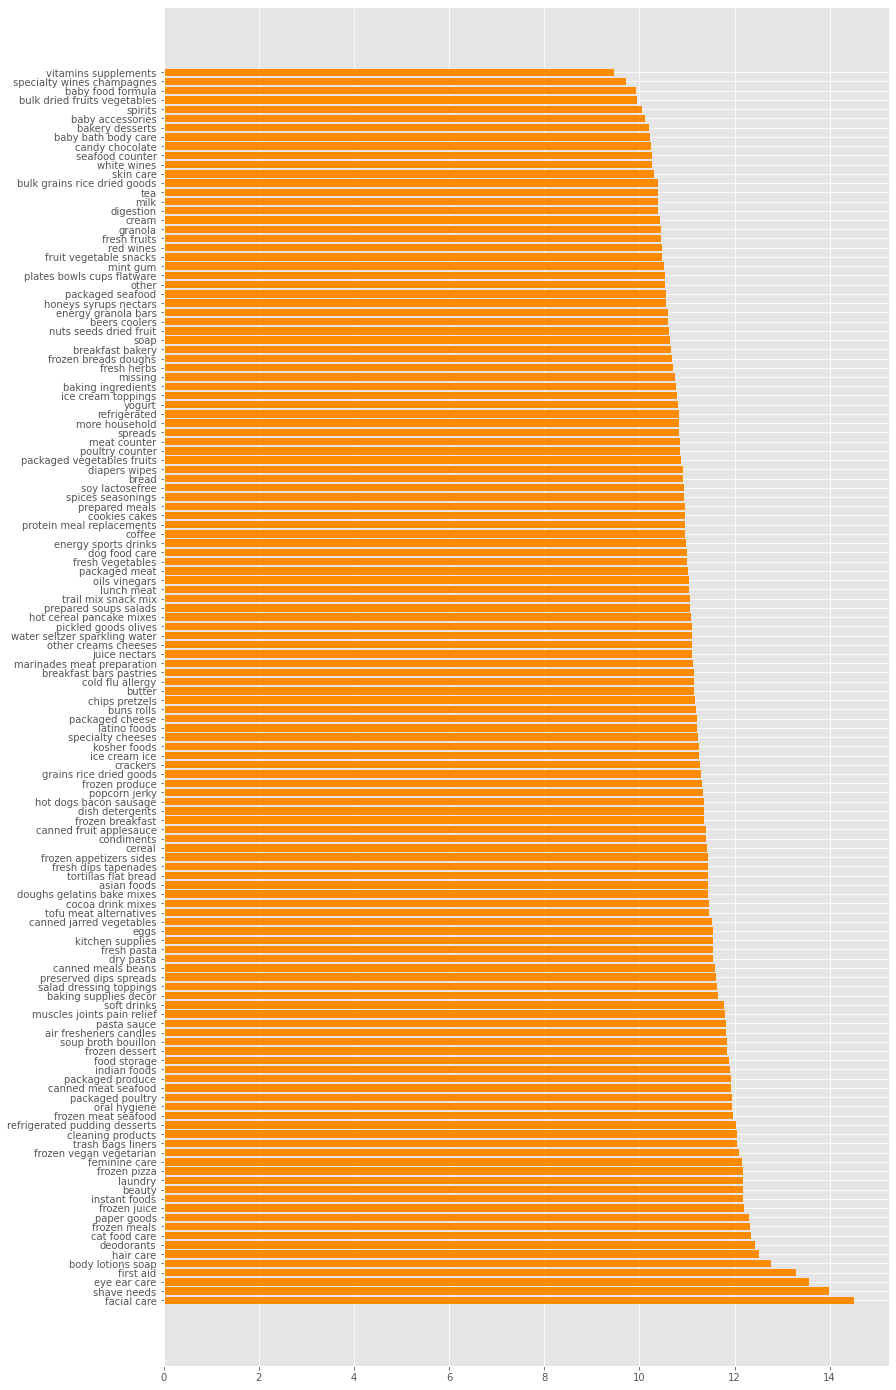

In [60]:
fig, ax = plt.subplots(figsize=(13,25))
ax.barh(dspo_by_aisle.index, dspo_by_aisle.values, color='darkorange');

A wider variety emerges here with days_since_prior_order among aisles. Vitamins, alcohol, baby products, candy, and seafood make for quite the interesting group of most-frequently ordered aisles. On the other end of the spectrum, it looks like beauty products come together to be ordered least frequently. These may be things that last longer or are used more gradually.

## Specifying recommendations with Linear Regression analysis:

Applying a linear regression model to this dataset with the goal of predicting what users will order next makes it difficult to select a single target variable. Instead, regression analysis will hopefully help determine which factors influence product selection the most. 

The EDA I've done was able to give me a more general impression of which features to consider, but now it's time to nail down some more specifics. It seems like the following relationships seem to correlate strongly or at last made for some interesting insights:

- add-to-cart orders versus their percentage-likelihood-to-be-a-reorder was a big one
- the enormous nature of the produce & 'dairy egg' departments probably shouldn't be ignored
- the weekend's order density seems noteworthy alongside the frequency of people ordering once-a-week

Of course, we can also put together a larger DataFrame and run a correlation heatmap to see what else we see. First, let's bring together a broader DataFrame that includes products, reordering percentages, and time-related aspects all in one place:

In [70]:
broader_product_df = pd.read_sql(
                """SELECT
                    opp.product_id,
                    p.product_name,
                    p.department_id,
                    d.department AS dept_name,
                    p.aisle_id,
                    a.aisle AS aisle_name,
                    AVG(o.order_dow) AS avg_order_day_of_week,
                    AVG(o.order_hour_of_day) AS avg_order_hour_of_day,
                    AVG(o.days_since_prior_order) AS avg_days_since_prior_order,
                    AVG(opp.add_to_cart_order) AS avg_added_to_cart_order,
                    COUNT(product_id) AS times_ordered,                    
                    SUM(opp.reordered) AS times_reordered                    
                FROM orders AS o
                JOIN order_products__prior AS opp
                    USING(order_id)
                JOIN products AS p
                    USING(product_id)
                JOIN aisles AS a
                    USING(aisle_id)
                JOIN departments AS d
                    USING(department_id)
                GROUP BY product_id
                ORDER BY product_id;
                """, conn)
broader_product_df

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered
0,1,Chocolate Sandwich Cookies,19,snacks,61,cookies cakes,2.573770,13.786885,12.627119,5.786885,61,42
1,2,All-Seasons Salt,13,pantry,104,spices seasonings,1.333333,13.000000,14.666667,12.000000,3,0
2,3,Robust Golden Unsweetened Oolong Tea,7,beverages,94,tea,3.000000,12.666667,20.666667,3.000000,3,2
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,1,frozen,38,frozen meals,3.500000,14.300000,12.500000,9.000000,10,3
4,8,Cut Russet Potatoes Steam N' Mash,1,frozen,116,frozen produce,0.500000,13.500000,4.000000,9.500000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35444,49681,Spaghetti with Meatballs and Sauce Meal,1,frozen,38,frozen meals,1.000000,17.000000,26.000000,11.000000,1,1
35445,49683,Cucumber Kirby,4,produce,83,fresh vegetables,2.555770,13.558020,12.366470,7.699132,3111,2135
35446,49685,En Croute Roast Hazelnut Cranberry,1,frozen,42,frozen vegan vegetarian,3.666667,8.666667,19.000000,9.000000,3,1
35447,49686,Artisan Baguette,3,bakery,112,bread,2.428571,9.000000,8.833333,6.428571,7,5


Now we need to add the reorder_percentage column in and re-run the missing department & aisle fix for popular products:

In [73]:
#Percentage_as_reorder_column:
broader_product_df['percentage_as_a_reorder'] = broader_product_df['times_reordered'] / broader_product_df['times_ordered']
#Re-running the missing department & aisle fix for the popular products:
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Riced Cauliflower', 'aisle_name'] = 'fresh vegetables'

broader_product_df.loc[broader_product_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Mango Yogurt', 'aisle_name'] = 'yogurt'

broader_product_df.loc[broader_product_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
broader_product_df.loc[broader_product_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'aisle_name'] = 'ice cream ice'

broader_product_df.loc[broader_product_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'

broader_product_df.loc[broader_product_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'aisle_name'] = 'yogurt'

broader_product_df.head()

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered,percentage_as_a_reorder
0,1,Chocolate Sandwich Cookies,19,snacks,61,cookies cakes,2.573770,13.786885,12.627119,5.786885,61,42,0.688525
1,2,All-Seasons Salt,13,pantry,104,spices seasonings,1.333333,13.000000,14.666667,12.000000,3,0,0.000000
2,3,Robust Golden Unsweetened Oolong Tea,7,beverages,94,tea,3.000000,12.666667,20.666667,3.000000,3,2,0.666667
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,1,frozen,38,frozen meals,3.500000,14.300000,12.500000,9.000000,10,3,0.300000
4,8,Cut Russet Potatoes Steam N' Mash,1,frozen,116,frozen produce,0.500000,13.500000,4.000000,9.500000,2,0,0.000000


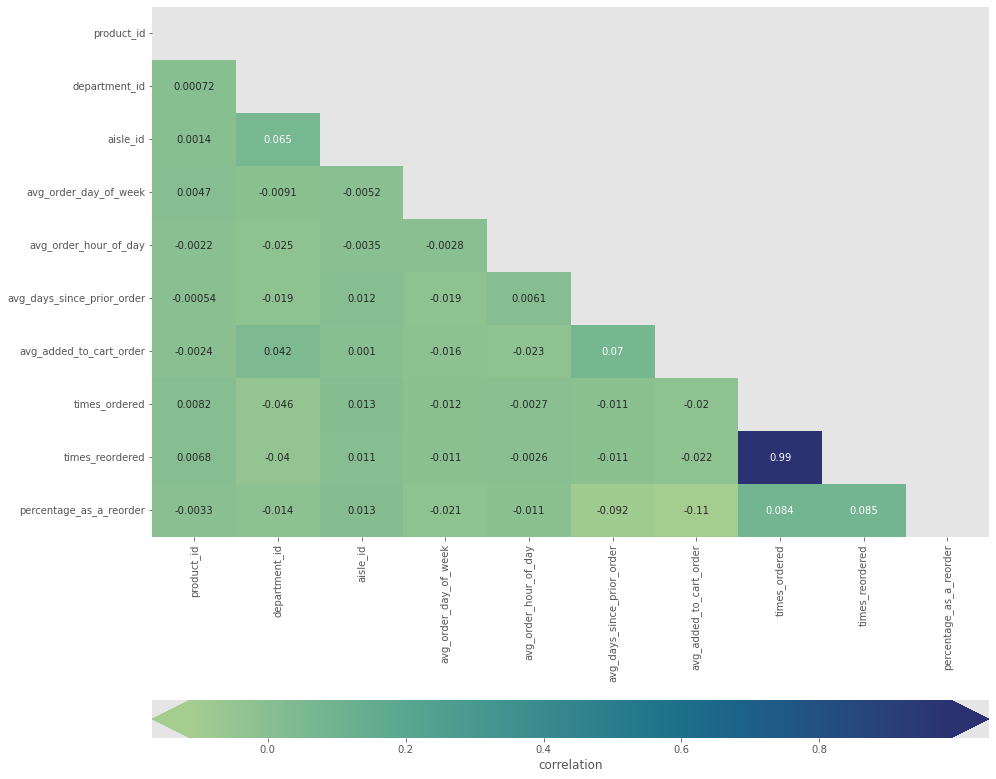

In [77]:
#Building the correlation heatmap:
import seaborn as sns
heatmap_data = broader_product_df
corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, mask=np.triu(corr), ax=ax, annot=True, cmap="crest",
            cbar_kws={'label':'correlation', 'orientation':'horizontal', 'pad':.2, 'extend':'both'});

Besides the obvious and redundant correlation between times_ordered & times_reordered, there aren't too many compelling correlations here. However, there are a few that are stronger than others and may merit further investigation. 

The next two strongest correlations appear in the percentage_as_a_reorder column:
- with avg_added_to_cart_order at -0.11 
- with avg_days_since_prior_order at -0.092

Perhaps I can run a linear regression model with this column as the target. The next two strongest correlations also involve percentage_as_a_reorder, but they're redundant because they're what constitutes percentage_as_a_reorder (the two correlations to times_ordered and times_reordered). 

Two other correlations that may be worth looking into pertain to avg_added_to_cart_order: 
- avg_added_to_cart_order and avg_days_since_prior_order (0.07)
- avg_added_to_cart_order and department_id (0.042)

Looking back to my biggest impressions from the EDA, it does seem like the biggest correlation we'll find here is between avg_added_to_cart_order and percentage_as_a_reorder. **In other words, people add their reorders in a cluster to the cart. Why does this feel underwhelming?**

**In any case, let's remember the project rubric on l.r. - start with a baseline model and iteratively improve on it. You have what you need for the baseline now: a target (percentage_as_a_reorder) and the single most compelling feature (avg_added_to_cart_order). Run it in StatsModels and then...somehow...improve on it iteratively.**

In [79]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
formula = 'percentage_as_a_reorder ~ avg_added_to_cart_order'
model = ols(formula=formula, data=broader_product_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.013
Model:                                 OLS   Adj. R-squared:                  0.013
Method:                      Least Squares   F-statistic:                     452.1
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):           1.06e-99
Time:                             14:00:38   Log-Likelihood:                -10489.
No. Observations:                    35449   AIC:                         2.098e+04
Df Residuals:                        35447   BIC:                         2.100e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4854      0.004    137.240      0.000       0.478       0.492
avg_added_to_cart_order    -0.0073      0.000    -21.263      0.000      -0.008      -0.007
==============================================================================
Omnibus:                     6135.661   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1452.562
Skew:                           0.156   Prob(JB):                         0.00
Kurtosis:                       2.059   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That's a rough R-squared score. On one hand, it should be easy to beat. On the other hand, I'm worried about how compelling any future regression results will be. Oh well, let's visualize this correlation:

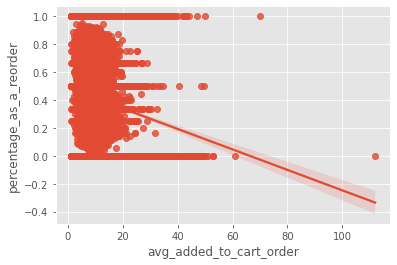

In [82]:
sns.regplot(x='avg_added_to_cart_order', y='percentage_as_a_reorder', data=broader_product_df);

In [83]:
#fig, ax = plt.subplots()
#ax.scatter(broader_product_df['avg_added_to_cart_order'], broader_product_df['percentage_as_a_reorder'], alpha=0.2)
#ax.plot()
#ax.set_xlabel('avg_added_to_cart_order')
#ax.set_ylabel('percentage_as_a_reorder')
#ax.set_title("Correlation of a product's cart-add-order and its likelihood of constituting a reorder");

In [80]:
broader_product_df['percentage_as_a_reorder'].value_counts()

0.000000    9438
1.000000    3924
0.500000    3347
0.333333    1698
0.666667    1392
            ... 
0.590062       1
0.616495       1
0.629808       1
0.602914       1
0.642276       1
Name: percentage_as_a_reorder, Length: 2512, dtype: int64

What a mess. We have too many single-ordered products at 0%; we can probably just get rid of them because they are obscure products that don't really inform reordering. However, they do constitute 26% of our broader_product_df. Well, I suppose if the end-goal is to better predict future orders, then these unpopular 0% reorder products probably don't really matter, so we'll drop them.

In [88]:
broader_product_df = broader_product_df[broader_product_df['percentage_as_a_reorder'] != 0]
broader_product_df['percentage_as_a_reorder'].value_counts()

1.000000    3924
0.500000    3347
0.333333    1698
0.666667    1392
0.250000     829
            ... 
0.590062       1
0.616495       1
0.629808       1
0.602914       1
0.642276       1
Name: percentage_as_a_reorder, Length: 2511, dtype: int64

We also have a ton of 100%-reordered products, which seems odd and warrants further investigation. 

In [91]:
broader_product_df[broader_product_df['percentage_as_a_reorder'] == 1]

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered,percentage_as_a_reorder
9,15,Overnight Diapers Size 6,18,babies,56,diapers wipes,2.000000,7.000000,4.000000,1.000000,1,1,1.0
20,33,Organic Spaghetti Style Pasta,9,dry goods pasta,131,dry pasta,3.000000,10.666667,10.666667,14.666667,3,3,1.0
27,41,Organic Sourdough Einkorn Crackers Rosemary,19,snacks,78,crackers,2.500000,17.500000,29.500000,9.500000,2,2,1.0
45,60,Cheesy Creations Roasted Garlic Parmesan Sauce,9,dry goods pasta,9,pasta sauce,5.000000,16.000000,30.000000,17.000000,1,1,1.0
52,68,"Pancake Mix, Buttermilk",14,breakfast,130,hot cereal pancake mixes,2.333333,17.000000,3.666667,1.666667,3,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35423,49648,Squid Ink Fettuccini,9,dry goods pasta,131,dry pasta,1.000000,9.000000,21.000000,8.000000,1,1,1.0
35424,49649,Refreshing Remover Cleansing Towelettes,11,personal care,73,facial care,6.000000,12.000000,15.000000,2.000000,1,1,1.0
35437,49674,Frozen Greek Yogurt Bars Chocolate Chip,1,frozen,37,ice cream ice,4.000000,22.000000,1.000000,2.000000,1,1,1.0
35439,49676,Ultra Red Energy Drink,7,beverages,64,energy sports drinks,1.000000,13.000000,12.000000,9.000000,1,1,1.0


Ah, this is due to products that have only been ordered once or just a few times and each time it was a reorder. This points to the fact that items appearing on here once are influencing the regression analysis *just as much* as bananas are with over 150,000 orders. This goes back to the fact that I'm grouping by products in this df, which I did because the goal is to predict *products*, but maybe there's another way to do this. Could I maybe group by order and...hmm, not sure how I'd get the product info, though.

Well, let's take a look at these more obscure items if we were to, say, define "obscure" as ordered fewer than five times:

In [181]:
no_of_obscure_orders = len(broader_product_df[broader_product_df['times_ordered'] < 5])

print("Length of broader_product_df:", len(broader_product_df))
print("Number of obscure product records:", no_of_obscure_orders)
print("Percentage that these obscure orders take up:", round(no_of_obscure_orders/len(broader_product_df),3))

Length of broader_product_df: 26011
Number of obscure product records: 9130
Percentage that these obscure orders take up: 0.351


Hmm, that's a lot. I wonder if there's a way for me to weigh these or perhaps I could standardaize them with a logarithmic transformation. Let's look at the distribution: 

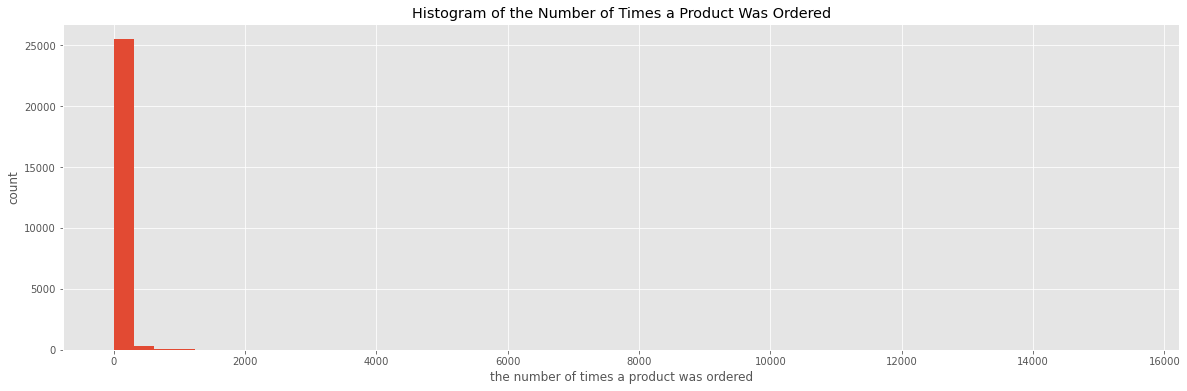

In [118]:
fig, ax = plt.subplots(figsize=(20,6))
ax.hist(broader_product_df['times_ordered'], bins=50)
#plt.xticks(ticks=np.arange(0,31,1))
ax.set_title('Histogram of the Number of Times a Product Was Ordered')
ax.set_xlabel('the number of times a product was ordered')
ax.set_ylabel('count');

In [115]:
broader_product_df['times_ordered'].value_counts()

2       2624
1       2592
3       2193
4       1721
5       1425
        ... 
776        1
1336       1
438        1
415        1
3111       1
Name: times_ordered, Length: 689, dtype: int64

So, definitely not a normal distribution. I'm guessing the same goes for reorders, but let's make sure:

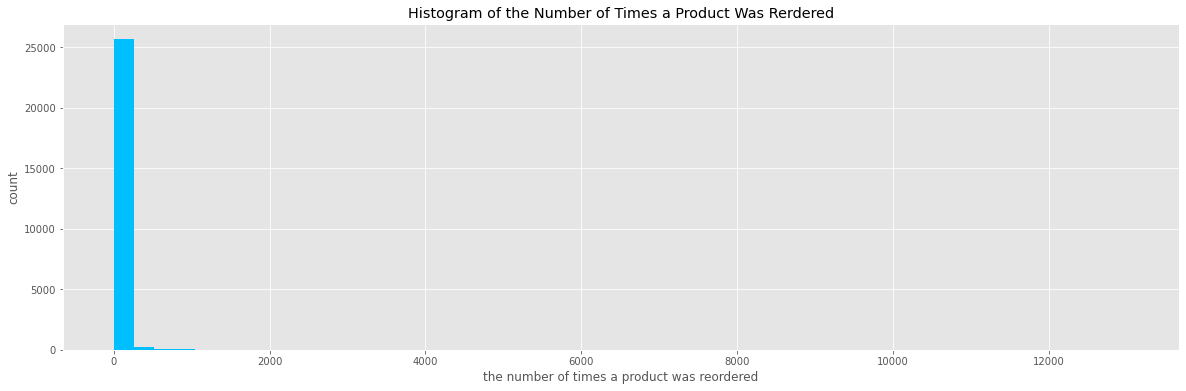

In [119]:
fig, ax = plt.subplots(figsize=(20,6))
ax.hist(broader_product_df['times_reordered'], bins=50, color="deepskyblue")
#plt.xticks(ticks=np.arange(0,31,1))
ax.set_title('Histogram of the Number of Times a Product Was Rerdered')
ax.set_xlabel('the number of times a product was reordered')
ax.set_ylabel('count');

Same here, but before performing a logarithmic transformation, let's look at the residuals of these columns. In order to do so, we'll need to set up our first improvement iteration model against the baseline above with a multiple regressio model.

In [137]:
broader_product_df.head()

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered,percentage_as_a_reorder,times_ordered_log,times_reordered_log
0,1,Chocolate Sandwich Cookies,19,snacks,61,cookies cakes,2.573770,13.786885,12.627119,5.786885,61,42,0.688525,4.110874,3.737670
2,3,Robust Golden Unsweetened Oolong Tea,7,beverages,94,tea,3.000000,12.666667,20.666667,3.000000,3,2,0.666667,1.098612,0.693147
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,1,frozen,38,frozen meals,3.500000,14.300000,12.500000,9.000000,10,3,0.300000,2.302585,1.098612
5,9,Light Strawberry Blueberry Yogurt,16,dairy eggs,120,yogurt,2.500000,14.000000,7.000000,10.500000,2,1,0.500000,0.693147,0.000000
6,10,Sparkling Orange Juice & Prickly Pear Beverage,7,beverages,115,water seltzer sparkling water,3.215385,14.123077,11.000000,8.107692,65,31,0.476923,4.174387,3.433987


In [163]:
target = broader_product_df['percentage_as_a_reorder']
predictors = broader_product_df[['department_id', 'aisle_id', 'avg_order_day_of_week', 'avg_order_hour_of_day', \
                                'avg_days_since_prior_order', 'avg_added_to_cart_order', 'times_ordered', \
                                'times_reordered']]
predictors = sm.add_constant(predictors)
predictors.head(3)

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,department_id,aisle_id,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered
0,1.0,19,61,2.57377,13.786885,12.627119,5.786885,61,42
2,1.0,7,94,3.00000,12.666667,20.666667,3.000000,3,2
3,1.0,1,38,3.50000,14.300000,12.500000,9.000000,10,3


In [164]:
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.051
Model:                                 OLS   Adj. R-squared:                  0.051
Method:                      Least Squares   F-statistic:                     175.6
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):          4.10e-290
Time:                             21:09:19   Log-Likelihood:                 604.67
No. Observations:                    26011   AIC:                            -1191.
Df Residuals:                        26002   BIC:                            -1118.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.7236      0.012     60.844      0.000       0.700       0.747
department_id                  0.0001      0.000      0.496      0.620      -0.000       0.001
aisle_id                    2.989e-05   3.84e-05      0.777      0.437   -4.55e-05       0.000
avg_order_day_of_week         -0.0007      0.001     -0.522      0.602      -0.004       0.002
avg_order_hour_of_day         -0.0017      0.001     -2.476      0.013      -0.003      -0.000
avg_days_since_prior_order    -0.0043      0.000    -13.246      0.000      -0.005      -0.004
avg_added_to_cart_order       -0.0083      0.000    -22.675      0.000      -0.009      -0.008
times_ordered                 -0.0013   5.32e-05    -24.163      0.000      -0.001      -0.001
times_reordered                0.0017   7.06e-05     24.766      0.000       0.002       0.002
==============================================================================
Omnibus:                      381.816   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.879
Skew:                           0.274   Prob(JB):                     2.21e-90
Kurtosis:                       3.285   Cond. No.                     2.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Worse than the baseline in terms of its R-squared score *and* the condition number. Not even worth being the first iteration towards improving on the baseline. The condition number is probably being blown u p by the times_ordered/times_reordered inclusion, too. What about just times_ordered?

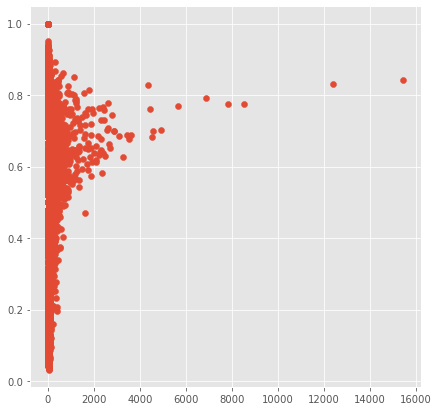

In [156]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(broader_product_df['times_ordered'], broader_product_df['percentage_as_a_reorder']);

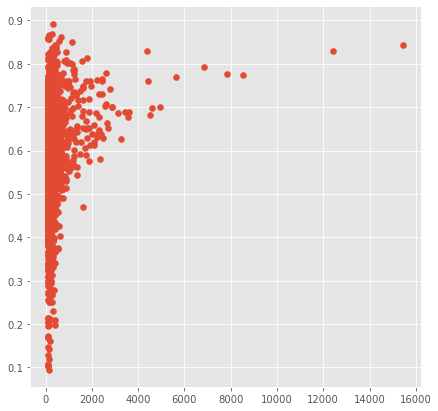

In [158]:
#Just out of curiosity:
products_worth_considering = broader_product_df[broader_product_df['times_ordered'] > 100]
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(products_worth_considering['times_ordered'], products_worth_considering['percentage_as_a_reorder']);

In [146]:
formula = 'percentage_as_a_reorder ~ times_ordered'
model = ols(formula=formula, data=broader_product_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     45.21
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):           1.81e-11
Time:                             18:44:30   Log-Likelihood:                -57.040
No. Observations:                    26011   AIC:                             118.1
Df Residuals:                        26009   BIC:                             134.4
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5706      0.002    375.347      0.000       0.568       0.574
times_reordered  6.297e-05   9.37e-06      6.724      0.000    4.46e-05    8.13e-05
==============================================================================
Omnibus:                     1430.774   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              942.658
Skew:                           0.348   Prob(JB):                    2.02e-205
Kurtosis:                       2.379   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

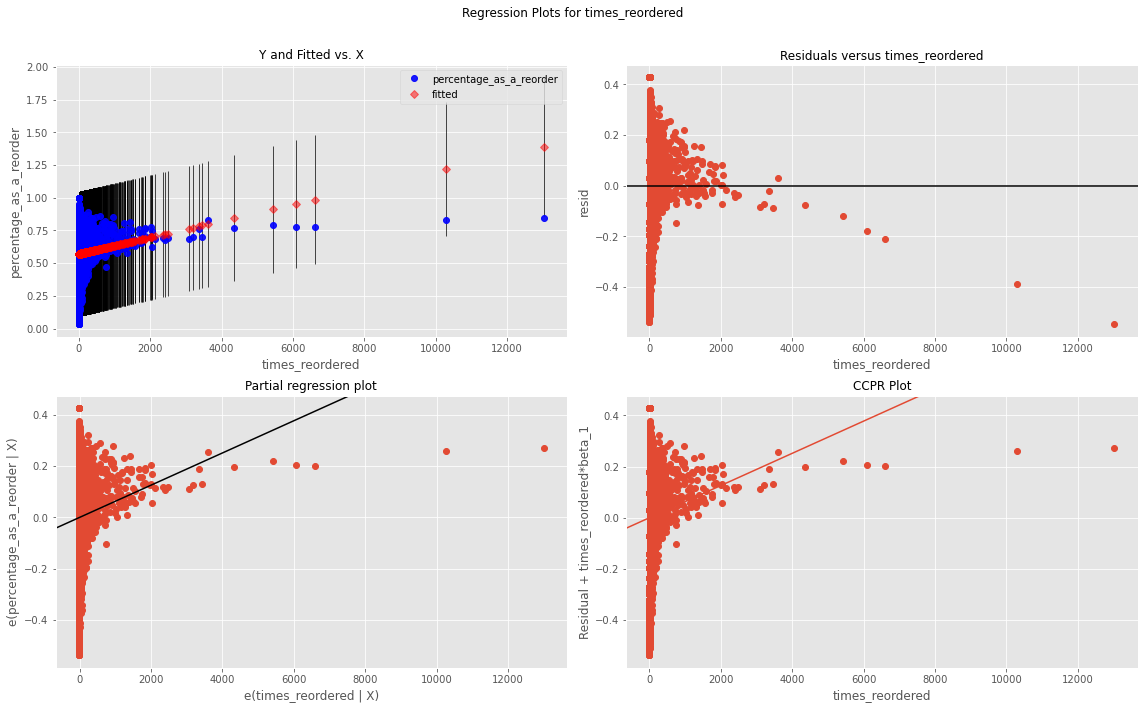

In [155]:
fig = plt.figure(figsize=(16,10))
fig = sm.graphics.plot_regress_exog(model, "times_reordered", fig=fig)

In [166]:
#Rough. Ok, let's just log-transform times_ordered and reordered and see (but, of course, we'll just do
# one of those two for now):

In [159]:
broader_product_df['times_ordered_log'] = np.log(broader_product_df['times_ordered'])
broader_product_df['times_reordered_log'] = np.log(broader_product_df['times_reordered'])

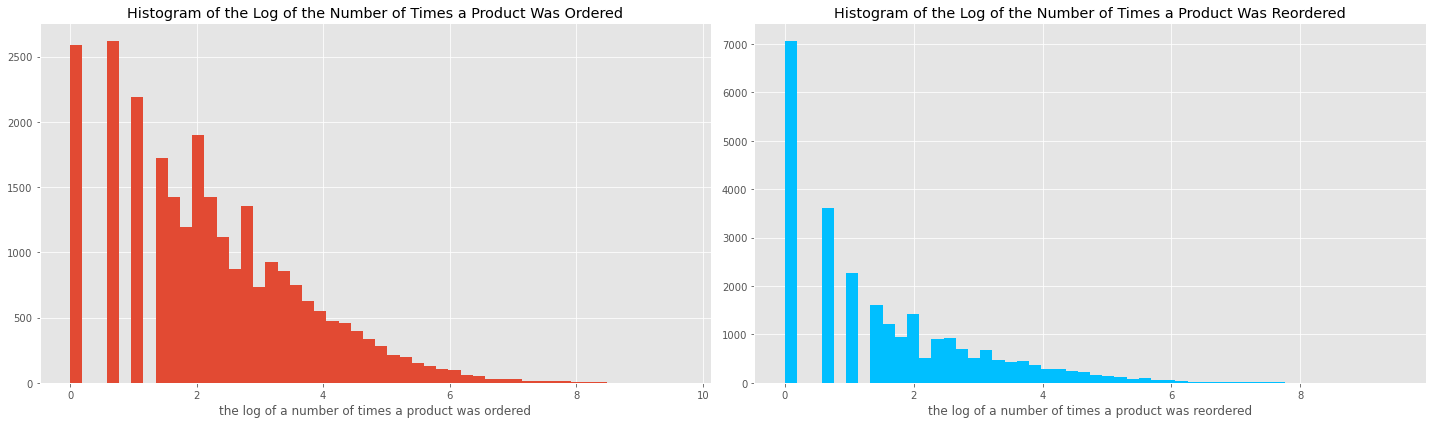

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.hist(broader_product_df['times_ordered_log'], bins=50)
ax2.hist(broader_product_df['times_reordered_log'], color='deepskyblue', bins=50)
#plt.xticks(ticks=np.arange(0,31,1))
ax1.set_title('Histogram of the Log of the Number of Times a Product Was Ordered')
ax2.set_title('Histogram of the Log of the Number of Times a Product Was Reordered')
ax1.set_xlabel('the log of a number of times a product was ordered')
ax2.set_xlabel('the log of a number of times a product was reordered')
ax.set_ylabel('count')
plt.tight_layout();

In [162]:
#Could be worse, at least it's an improvement.
formula = 'percentage_as_a_reorder ~ times_ordered_log'
model = ols(formula=formula, data=broader_product_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.091
Model:                                 OLS   Adj. R-squared:                  0.090
Method:                      Least Squares   F-statistic:                     2588.
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                             21:07:15   Log-Likelihood:                 1154.2
No. Observations:                    26011   AIC:                            -2304.
Df Residuals:                        26009   BIC:                            -2288.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6812      0.003    263.985      0.000       0.676       0.686
times_ordered_log    -0.0491      0.001    -50.874      0.000      -0.051      -0.047
==============================================================================
Omnibus:                     6605.206   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1127.318
Skew:                          -0.026   Prob(JB):                    1.61e-245
Kurtosis:                       1.981   Cond. No.                         5.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not too shabby. Let's throw some more stuff in there for the first real attempt at a multiple regression analysis:

In [168]:
target = broader_product_df['percentage_as_a_reorder']
predictors = broader_product_df[['avg_order_day_of_week', 'avg_order_hour_of_day', \
                                'avg_days_since_prior_order', 'avg_added_to_cart_order', 'times_ordered_log', \
                                'times_reordered']]
predictors = sm.add_constant(predictors)

In [169]:
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.140
Model:                                 OLS   Adj. R-squared:                  0.140
Method:                      Least Squares   F-statistic:                     705.9
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                             21:14:21   Log-Likelihood:                 1882.9
No. Observations:                    26011   AIC:                            -3752.
Df Residuals:                        26004   BIC:                            -3695.
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.8437      0.011     77.560      0.000       0.822       0.865
avg_order_day_of_week         -0.0024      0.001     -1.752      0.080      -0.005       0.000
avg_order_hour_of_day         -0.0018      0.001     -2.754      0.006      -0.003      -0.001
avg_days_since_prior_order    -0.0041      0.000    -13.381      0.000      -0.005      -0.003
avg_added_to_cart_order       -0.0083      0.000    -23.656      0.000      -0.009      -0.008
times_ordered_log             -0.0578      0.001    -57.735      0.000      -0.060      -0.056
times_reordered                0.0002   9.27e-06     25.992      0.000       0.000       0.000
==============================================================================
Omnibus:                      123.091   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.501
Skew:                          -0.137   Prob(JB):                     5.04e-26
Kurtosis:                       2.819   Cond. No.                     1.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
#Inexcusable condition number. Let's just tack times_ordered_log on to avg_added_to_cart_order:
target = broader_product_df['percentage_as_a_reorder']
predictors = broader_product_df[['avg_added_to_cart_order', 'times_ordered_log']]
predictors = sm.add_constant(predictors)

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [171]:
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.111
Model:                                 OLS   Adj. R-squared:                  0.111
Method:                      Least Squares   F-statistic:                     1626.
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                             21:15:37   Log-Likelihood:                 1452.8
No. Observations:                    26011   AIC:                            -2900.
Df Residuals:                        26008   BIC:                            -2875.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.7571      0.004    188.944      0.000       0.749       0.765
avg_added_to_cart_order    -0.0087      0.000    -24.580      0.000      -0.009      -0.008
times_ordered_log          -0.0489      0.001    -51.202      0.000      -0.051      -0.047
==============================================================================
Omnibus:                     3595.161   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.766
Skew:                          -0.011   Prob(JB):                    5.55e-192
Kurtosis:                       2.099   Cond. No.                         28.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [172]:
#Slightly worse than the baseline. Okay, let's throw in some more shit, but try to be 
# more careful about multicollinearity ˋ( ° ▽、° ) 
target = broader_product_df['percentage_as_a_reorder']
predictors = broader_product_df[['avg_order_day_of_week', 'avg_order_hour_of_day', \
                                'avg_days_since_prior_order', 'avg_added_to_cart_order', 'times_ordered_log']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.118
Model:                                 OLS   Adj. R-squared:                  0.118
Method:                      Least Squares   F-statistic:                     694.0
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                             21:18:23   Log-Likelihood:                 1549.4
No. Observations:                    26011   AIC:                            -3087.
Df Residuals:                        26005   BIC:                            -3038.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.8339      0.011     75.731      0.000       0.812       0.856
avg_order_day_of_week         -0.0025      0.001     -1.809      0.070      -0.005       0.000
avg_order_hour_of_day         -0.0018      0.001     -2.787      0.005      -0.003      -0.001
avg_days_since_prior_order    -0.0042      0.000    -13.518      0.000      -0.005      -0.004
avg_added_to_cart_order       -0.0086      0.000    -24.158      0.000      -0.009      -0.008
times_ordered_log             -0.0488      0.001    -51.296      0.000      -0.051      -0.047
==============================================================================
Omnibus:                     3035.294   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.982
Skew:                          -0.008   Prob(JB):                    1.76e-177
Kurtosis:                       2.134   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hell yes - there it is, an improvement on the baseline score. Done-zo! Instacart: consider these factors when predicting what people will order. When in doubt, expect bananas! 🍌 Joey out *mic drop* 



J/K. Yes, this is an improvement. However, that R-squared score indictaes this model isn't very helpful when it 
comes to explaining the percentage of a product's orders that are reorders. What about our earlier correlation
heatmap and how it showed a relationship with avg_days_since_prior_order? 

Let's add it with avg_added_to_cart_order first:

In [175]:
target = broader_product_df['percentage_as_a_reorder']
predictors = broader_product_df[['avg_added_to_cart_order', 'avg_days_since_prior_order']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.028
Model:                                 OLS   Adj. R-squared:                  0.028
Method:                      Least Squares   F-statistic:                     377.6
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):          2.18e-162
Time:                             21:28:17   Log-Likelihood:                 292.66
No. Observations:                    26011   AIC:                            -579.3
Df Residuals:                        26008   BIC:                            -554.8
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.6971      0.005    139.084      0.000       0.687       0.707
avg_added_to_cart_order       -0.0087      0.000    -23.452      0.000      -0.009      -0.008
avg_days_since_prior_order    -0.0043      0.000    -13.353      0.000      -0.005      -0.004
==============================================================================
Omnibus:                      884.992   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              809.327
Skew:                           0.379   Prob(JB):                    1.81e-176
Kurtosis:                       2.586   Cond. No.                         50.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nope. The R-squared went down and the condition number crept up. What if I add times_ordered_log in?

In [176]:
target = broader_product_df['percentage_as_a_reorder']
predictors = broader_product_df[['avg_added_to_cart_order', 'avg_days_since_prior_order', 'times_ordered_log']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.117
Model:                                 OLS   Adj. R-squared:                  0.117
Method:                      Least Squares   F-statistic:                     1153.
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                             21:30:21   Log-Likelihood:                 1543.9
No. Observations:                    26011   AIC:                            -3080.
Df Residuals:                        26007   BIC:                            -3047.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.8021      0.005    154.322      0.000       0.792       0.812
avg_added_to_cart_order       -0.0085      0.000    -24.093      0.000      -0.009      -0.008
avg_days_since_prior_order    -0.0042      0.000    -13.517      0.000      -0.005      -0.004
times_ordered_log             -0.0487      0.001    -51.248      0.000      -0.051      -0.047
==============================================================================
Omnibus:                     3075.010   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              819.020
Skew:                          -0.008   Prob(JB):                    1.42e-178
Kurtosis:                       2.131   Cond. No.                         55.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Slightly worse than our best improvement-attempt of 0.118. Hmm, well like we said earlier (and Mark said too), l.r. isn't here to predict, but to help explain and explore. We thought maybe percentage_as_a_reorder could make a good target, but it doesn't. I think part of the problem is that fact that we're not really satisfying the requirements of linear regression because these distributions aren't normal and the target isn't one that's ripe for l.r.

I think we're coming to a head on the mixed nature of this project (Flatiron prompt, but I've already used the dataset before and had to find a new one). Reading through the Phase 2 Project Description, the project should involve SQL, data aggregation, and three business recommendations. Looking through what Mark sent me, it needs to have a baseline l.r. model and iterative improvements to it. 

I did the SQL and data aggregation stuff here, but this is not a l.r.-iterative-friendly dataset. 

Ok, wait, I have an idea that circles back to the beginning of this project. **Only frequently-ordered products are going to help you predict what's going to be reordered. Even if we lose a lot of product records in the broader_product_df by only focusing on more frequently ordered products, that's fine because the remaining products are the ones that get meaningfully reordered in the first place. Products that are barely ordered aren't going to be useful for predicting purposes. So, the only question is how many to drop? As many as it takes to get a meaningful R-squared (lol, but also...maybe because at least then you'll have a useful model for the products whose stock is largest and needs to be refilled most often?). IDK, products ordered < 100 times seems reasonable and still leaves 1,856 products in the mix.**

Oh, and you need to **reframe this entire project as aimed at a grocery company's business inquiry into restocking AND into their own curbside/delivery service. After all, Instacart is struggling and stores do this sort of thing on their own now. Specifically, (1) which n-amount of products to be sure to restock/predict, (2) which day of the week to be sure to restock/predict them, and ~~(3) which hour of the day to do so and nevermind, that brings in too much multicollinearity, so~~ maybe (3) you might even be able to put together a df on typical new items for customers to help them know what to recommend.** 

The use of SQL and EDA/aggregating stuff can remain and it's utility is still easily justified here, but l.r. could come in when explaining what contributes to a product's likelihood of being reordered, which we discover below are the following:

- added_to_cart_order and 
- times_ordered_log
- avg_days_since_prior_order
- avg_order_day_of_week

So, we can then recommend to grocers' curbside/delivery services what to expect since they're the shoppers and the suppliers. This goes into telling them what factors to consider when recommending new products, like what related most to someone picking out a new item?

In [209]:
products_worth_considering = broader_product_df[broader_product_df['times_ordered'] > 100]
products_worth_considering.shape

(1856, 15)

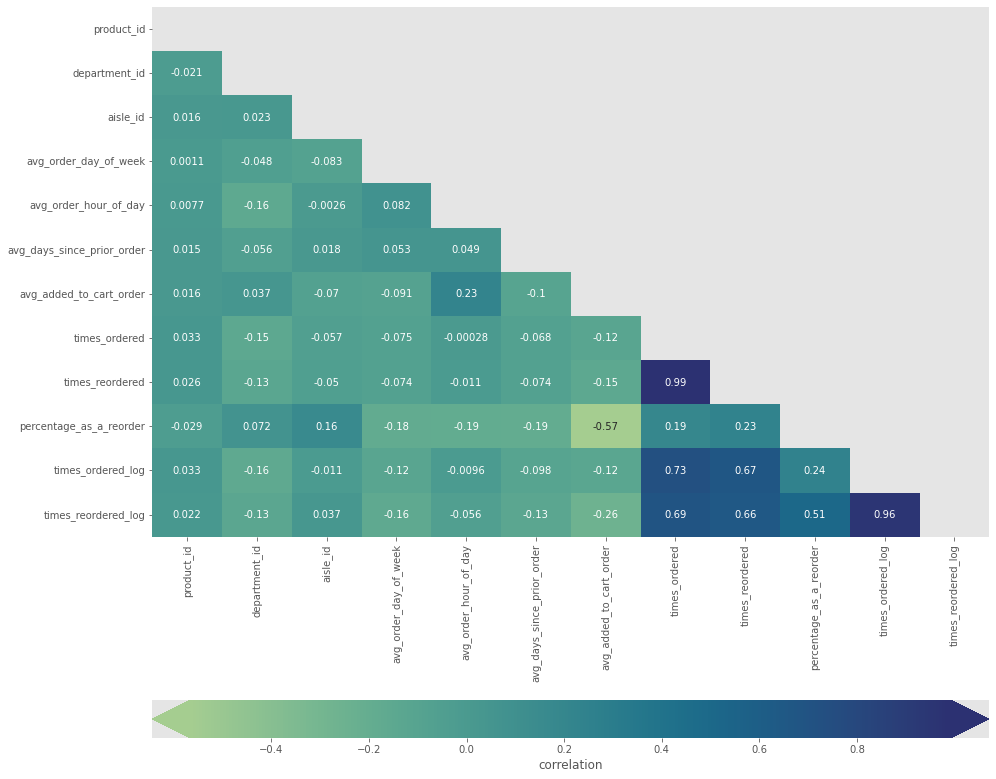

In [188]:
#Heatmap those correlations
heatmap_data = products_worth_considering
corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, mask=np.triu(corr), ax=ax, annot=True, cmap="crest",
            cbar_kws={'label':'correlation', 'orientation':'horizontal', 'pad':.2, 'extend':'both'});

In [210]:
#Refined df baseline:
formula = 'percentage_as_a_reorder ~ avg_added_to_cart_order'
model = ols(formula=formula, data=products_worth_considering).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.320
Model:                                 OLS   Adj. R-squared:                  0.320
Method:                      Least Squares   F-statistic:                     873.9
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):          1.09e-157
Time:                             23:39:20   Log-Likelihood:                 1549.7
No. Observations:                     1856   AIC:                            -3095.
Df Residuals:                         1854   BIC:                            -3084.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9592      0.013     76.203      0.000       0.935       0.984
avg_added_to_cart_order    -0.0434      0.001    -29.562      0.000      -0.046      -0.040
==============================================================================
Omnibus:                      291.263   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              520.425
Skew:                          -0.989   Prob(JB):                    9.80e-114
Kurtosis:                       4.678   Cond. No.                         44.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

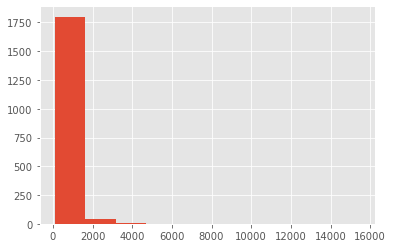

In [211]:
#Should I use times_ordered or times_ordered_log here?
products_worth_considering['times_ordered'].hist();
#Ah, definitely times_ordered_log

In [187]:
#Model with top features of products_worth_considering that still make sense together:
target = products_worth_considering['percentage_as_a_reorder']
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order', 'times_ordered_log']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.405
Model:                                 OLS   Adj. R-squared:                  0.404
Method:                      Least Squares   F-statistic:                     420.3
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):          3.33e-208
Time:                             23:02:39   Log-Likelihood:                 1673.2
No. Observations:                     1856   AIC:                            -3338.
Df Residuals:                         1852   BIC:                            -3316.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.1183      0.033     33.594      0.000       1.053       1.184
avg_added_to_cart_order       -0.0438      0.001    -31.446      0.000      -0.047      -0.041
avg_days_since_prior_order    -0.0263      0.002    -13.007      0.000      -0.030      -0.022
times_ordered_log              0.0248      0.003      8.199      0.000       0.019       0.031
==============================================================================
Omnibus:                      364.000   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.356
Skew:                          -1.090   Prob(JB):                    1.48e-182
Kurtosis:                       5.464   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
#Can't we do better? Let's add in some more features to see:
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order', \
                                         'avg_order_day_of_week', 'avg_order_hour_of_day', 'times_ordered_log']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.448
Model:                                 OLS   Adj. R-squared:                  0.447
Method:                      Least Squares   F-statistic:                     375.4
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):          7.60e-237
Time:                             23:08:22   Log-Likelihood:                 1742.5
No. Observations:                     1856   AIC:                            -3475.
Df Residuals:                         1851   BIC:                            -3447.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.5356      0.047     32.436      0.000       1.443       1.628
avg_added_to_cart_order       -0.0454      0.001    -33.692      0.000      -0.048      -0.043
avg_days_since_prior_order    -0.0256      0.002    -13.132      0.000      -0.029      -0.022
avg_order_day_of_week         -0.1413      0.012    -11.984      0.000      -0.164      -0.118
times_ordered_log              0.0204      0.003      6.937      0.000       0.015       0.026
==============================================================================
Omnibus:                      368.707   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.766
Skew:                          -1.089   Prob(JB):                    5.55e-192
Kurtosis:                       5.579   Cond. No.                         334.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not bad, but the condition number is probably just too high now. Remove hour_of_day, it's p-value is bad anyway. 

In [191]:
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order', \
                                         'avg_order_day_of_week', 'times_ordered_log']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

C:\Users\joelm\anaconda3again\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.448
Model:                                 OLS   Adj. R-squared:                  0.447
Method:                      Least Squares   F-statistic:                     375.4
Date:                     Wed, 27 Sep 2023   Prob (F-statistic):          7.60e-237
Time:                             23:09:04   Log-Likelihood:                 1742.5
No. Observations:                     1856   AIC:                            -3475.
Df Residuals:                         1851   BIC:                            -3447.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.5356      0.047     32.436      0.000       1.443       1.628
avg_added_to_cart_order       -0.0454      0.001    -33.692      0.000      -0.048      -0.043
avg_days_since_prior_order    -0.0256      0.002    -13.132      0.000      -0.029      -0.022
avg_order_day_of_week         -0.1413      0.012    -11.984      0.000      -0.164      -0.118
times_ordered_log              0.0204      0.003      6.937      0.000       0.015       0.026
==============================================================================
Omnibus:                      368.707   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.766
Skew:                          -1.089   Prob(JB):                    5.55e-192
Kurtosis:                       5.579   Cond. No.                         334.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ok, best so far. Now you can think about normal distributions:

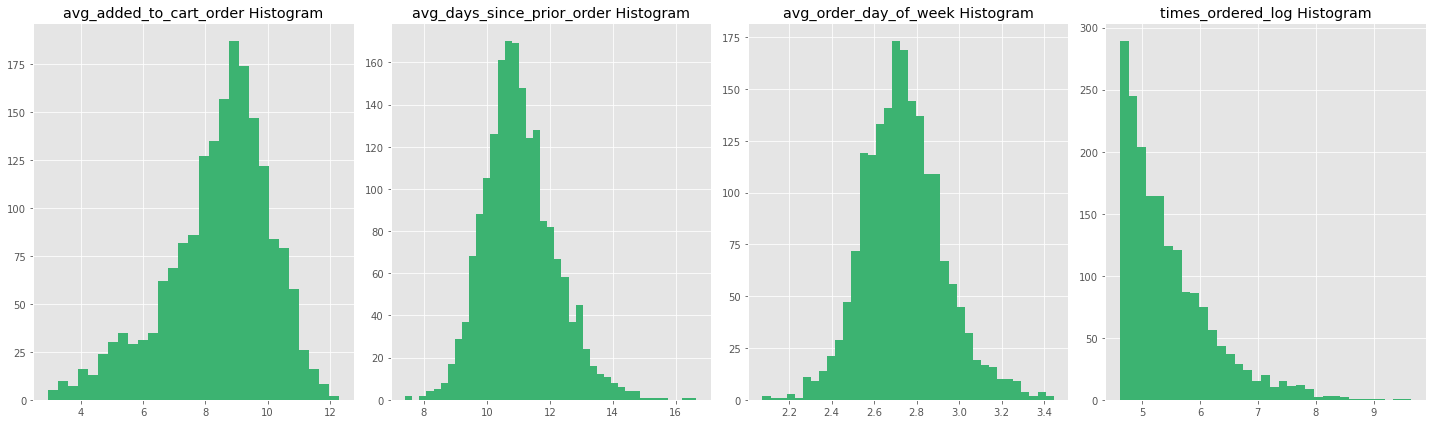

In [205]:
#Set up figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))
#Plot histograms
ax1.hist(products_worth_considering['avg_added_to_cart_order'], color='mediumseagreen', bins='auto')
ax2.hist(products_worth_considering['avg_days_since_prior_order'], color='mediumseagreen', bins='auto')
ax3.hist(products_worth_considering['avg_order_day_of_week'], color='mediumseagreen', bins='auto')
ax4.hist(products_worth_considering['times_ordered_log'], color='mediumseagreen', bins='auto')
#Title histograms
ax1.set_title('avg_added_to_cart_order Histogram')
ax2.set_title('avg_days_since_prior_order Histogram')
ax3.set_title('avg_order_day_of_week Histogram')
ax4.set_title('times_ordered_log Histogram')
#Polish figure
plt.tight_layout();

Yeah, not sure if I'd change anything here.

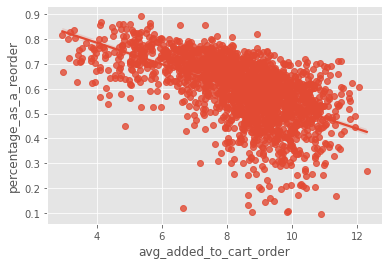

In [206]:
sns.regplot(x='avg_added_to_cart_order', y='percentage_as_a_reorder', data=products_worth_considering);
#FACT: reorders are usually put in the cart first

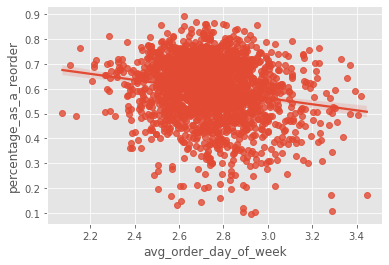

In [207]:
sns.regplot(x='avg_order_day_of_week', y='percentage_as_a_reorder', data=products_worth_considering);
#NOT SO MUCH A FACT AS A VIABLE TREND WORTH NOTING: reordered products are ordered more often 
# earlier in the week than later.